In [1]:
from collections import OrderedDict
#from matplotlib_venn import venn2, venn3
#from tqdm.notebook import tqdm
#tqdm.pandas()
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 1000)

import geopandas as gpd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time

import pdb
from IPython import display
from base64 import b64decode

# EDA of Richards Ave Station Arrivals

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8888199

the number of vehicle
arrivals for Richards Ave station near downtown Davis [see
Fig. 3(b)] [24]. The data of arrivals are the total number of the
passing-by vehicles. We use the scaled number of arrivals to
model the number of EVs that enter the charging station

In [2]:
# arrivals = pd.read_csv("../data/EV_Arrivals.csv")
# arrivals['timestamp'] = pd.to_datetime(arrivals['timestamp'])
# arrivals.describe()

In [3]:
arrivals = pd.read_csv("../../data/richards.csv")
arrivals['timestamp'] = pd.to_datetime(arrivals['timestamp'])
arrivals.describe()

flow1     occupancy1          flow2     occupancy2  \
count  812617.000000  812617.000000  812617.000000  812617.000000   
mean        8.432364       0.065904       8.184130       0.067233   
std         6.236347       0.084976       4.851408       0.078040   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.012200       4.000000       0.023300   
50%         8.000000       0.048900       9.000000       0.053300   
75%        13.000000       0.086700      12.000000       0.081100   
max        31.000000       0.998900      27.000000       0.999000   

               flow3     occupancy3      totalflow        weekday  \
count  812617.000000  812617.000000  812617.000000  812617.000000   
mean        4.901444       0.056069      21.517938       3.001845   
std         3.199595       0.074084      13.313527       2.009457   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.020000       9.000000       1.000000   
50%         5.000000       0.040000      22.000000       3.000000   
75%         7.000000       0.066700      32.000000       5.000000   
max        26.000000       0.998900      70.000000       6.000000   

                hour         minute         second  
count  812617.000000  812617.000000  812617.000000  
mean       11.493434      29.519285      15.000794  
std         6.911750      17.311128      15.000009  
min         0.000000       0.000000       0.000000  
25%         6.000000      15.000000       0.000000  
50%        12.000000      30.000000      30.000000  
75%        17.000000      45.000000      30.000000  
max        23.000000      59.000000      30.000000

In [4]:
arrivals.iloc[1000:1010]

timestamp  flow1  occupancy1  flow2  occupancy2  flow3  \
1000 2016-01-01 08:21:03      6      0.0300      5      0.0300      5   
1001 2016-01-01 08:21:33      4      0.0211      8      0.0422      1   
1002 2016-01-01 08:22:04      5      0.0256      6      0.0322      4   
1003 2016-01-01 08:22:34      0      0.0000      3      0.0156      5   
1004 2016-01-01 08:23:02      4      0.0200      7      0.0422      6   
1005 2016-01-01 08:23:33      3      0.0156      3      0.0178      4   
1006 2016-01-01 08:24:03     10      0.0533     17      0.1000      4   
1007 2016-01-01 08:24:33      4      0.0211      2      0.0100      3   
1008 2016-01-01 08:25:03      8      0.0422      5      0.0300      5   
1009 2016-01-01 08:25:34      9      0.0478     14      0.0767      6   

      occupancy3  totalflow  weekday  hour  minute  second  
1000      0.0300         16        4     8      21       0  
1001      0.0089         13        4     8      21      30  
1002      0.0200         15        4     8      22       0  
1003      0.0478          8        4     8      22      30  
1004      0.0322         17        4     8      23       0  
1005      0.0222         10        4     8      23      30  
1006      0.0222         31        4     8      24       0  
1007      0.0144          9        4     8      24      30  
1008      0.0278         18        4     8      25       0  
1009      0.0344         29        4     8      25      30

## Data Validation

Recreating the following plot: "Average hourly arrivals of different types of EVs."

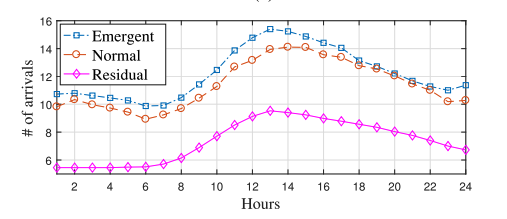

In [5]:
b64dat = "iVBORw0KGgoAAAANSUhEUgAAAfsAAADbCAYAAABqUDhQAAABV2lDQ1BJQ0MgUHJvZmlsZQAAGJVtkD9Lw1AUxU80UpCKRao4OGSoRbD+Ie3gJLQdRCgYWgV1S9KYCmn6SFLEXcGx4CQ4SP0CndRJHNwdFAcRVz+A2EVrvK9V06rvcbk/zjvvcLlAH1TGLBFA2fac/FJGWt/YlELP9CBiBFOYVHWXpRUlRxZ8997TvIfA++0Mz7psjEbmFodWrI/UWC56Mf3X33MGi4arU3+niuvM8QAhRqzseIwzFaIODUV8wNns8DFnrcONtmc1nyW+Jo7oJbVIfEec0Lp0s4vLVlX/moFPHzbstQKfh2oCBaQhI4l52sv/vlTbl0UFDLtwsA0TJXiQ6Ceja8EgXoYNHbNIEMuURpl8v7/3FmiVOrDwCvTXAk07As73gfGHQIudAMN7wNkNUx31Z5tCU3S3knKHwxlg4Mn3X+JA6BBo1Xz/re77rVPKfwSu7E+9BF+7+9yAKAAAAFZlWElmTU0AKgAAAAgAAYdpAAQAAAABAAAAGgAAAAAAA5KGAAcAAAASAAAARKACAAQAAAABAAAB+6ADAAQAAAABAAAA2wAAAABBU0NJSQAAAFNjcmVlbnNob3TywP1DAAAB1mlUWHRYTUw6Y29tLmFkb2JlLnhtcAAAAAAAPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iWE1QIENvcmUgNi4wLjAiPgogICA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPgogICAgICA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIgogICAgICAgICAgICB4bWxuczpleGlmPSJodHRwOi8vbnMuYWRvYmUuY29tL2V4aWYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj4yMTk8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+NTA3PC9leGlmOlBpeGVsWERpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6VXNlckNvbW1lbnQ+U2NyZWVuc2hvdDwvZXhpZjpVc2VyQ29tbWVudD4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+Cioz+EEAAEAASURBVHgB7F0HYFRFE/7Sew8JCSGN3nvvvTcBKSpSFRAERAUEBARBVJogTZqAoviLIIJKkd577xDSe+/1n9lwx6VfQnI5YAc29+69ffv2fXf3Znd25hudDBJIkQhIBF5LBIKCgjB+/Hhs3LgR1tbWamEwdepU1KlTB8OGDVOrvqwkEZAIlD4COlLZl/6HIHsgEShNBMLDw/HTTz9h4sSJBXbjwIEDcHZ2Rs2aNQusKytIBCQC2oOAVPba81nInkgEJAISAYmARKBEENAtkVZloxIBiYBEQCIgEZAIaA0CUtlrzUchOyIRkAhIBCQCEoGSQUAq+5LBVbYqEZAISAQkAhIBrUFAKnut+ShkRyQCEgGJgERAIlAyCEhlXzK4ylYlAhIBiYBEQCKgNQhIZa81H4XsiERAIiARkAhIBEoGAansSwZX2apEQCIgEZAISAS0BgGp7LXmo5AdkQhIBCQCEgGJQMkgIJV9yeAqW5UISAQkAhIBiYDWICCVvdZ8FLIjEgGJgERAIiARKBkEpLIvGVxlqxIBiYBEQCIgEdAaBKSy15qPQnZEIiARkAhIBCQCJYOAVPYlg6tsVSIgEZAISAQkAlqDgFT2WvNRyI5IBCQCEgGJgESgZBDQL5lmi7/VY8eOiUbbtGmjbPzp06dYu3YtYmNjMXLkSNSrV095TG5IBCQCEgGJgERAIpCJgNbP7BMSEnDq1CnMmjULrNwVEh0djaFDh6JKlSpo3749xo8fjzt37igOy1eJgERAIiARkAhIBJ4hoPUz+5MnT+LXX39FWlpalg/tl19+QbNmzTB8+HCx39LSEikpKVnqyDcSAYmAREAiIBGQCAA6GSQvAxATJ05Eo0aNMGzYMNHd999/Hw0bNkRERAR4lt+vXz80aNAgx600bdoUkZGR0NV9bsSwtraGhYVFjrr57QgICIC9vT0MDAzyq6aRY/Hx8eDC/dEGCQ4OBg+2jI2NS707SUlJ4vN2dHQs9b5wB8LCwgQuZmZmpd4fHjAHBgaiXLlypd4X7gD/LnV0dGBlZaUV/fH19YWzs3OWZ0VpdYyXJpOTk2Fra1taXchyXf7ecF8MDQ2z7C+NN2ztZXzKlClTGpdHUFCQ+GwUF+fPqXPnzli9erVil1a+av3MPi/U+EHB4PIggB/svGa/ceNGMQBQPYd/vDxIqFWrlnK3g4NDoX9EkydPxnvvvSceBsqGSmmDlzVOnDiB6dOnl1IPsl527ty56N27N+rXr5/1QCm8u3//PjZt2oSZM2eWwtVzXnLFihWoXr06OnXqlPOghvfwb2bGjBlag822bdvE4Hnw4MEaRiL3y40ZMwYff/wxTExMcq+gwb1///03Hj16hAkTJmjwqnlfinFhK6qHh0felTR05MKFC/j3339L7Xvs5eUFnlQoZNmyZVozYFX0KbfXl1bZ8wx79OjRQsnzjYWGhuK3337Loex59tu6dWsMHDgwt/tXe5++vr5QZpUrV1b7nJKqyDPpa9euifsqqWsUpl1TU1Oh0Bjn0hYjIyNw0Ya+MBY//vijeEBqQ3/4e6Onp6c12Bw4cECrPiu2/vHSIFupSltu374tLB/a8L1hLPg3VbduXdSpU6e0oUFMTAx4ebe0sMl+3VWrVhXaUlwaIL60yr5q1arCBKgAjZUxmwTzEx4QHDlyJL8qeR7jkRyPJlnJlrZcunRJmId5cKMNEhUVhdOnT4Nfi0vatm1bama64roH2Y5EQCIgEdAWBF5aZT9gwADhje/q6iqw3LJlizDj5wcsm8XY9N2hQ4f8quV6rEmTJrhx44YouVbQ8E42px08eFDDV839ctWqVYO/v78oudco3N7Dhw9j+/btUtkXDjZZWyIgEZAI5InAS6Ps+/Tpk2W9nGf2K1euxNatW4Vp8vvvv1drzZjPW79+fZ6AyAOlj0CvXr2K3Al3d3etWefkmxgyZIjWOMSxU+rUqVOLjG1xn9ijRw+tcHhV3Nenn36qFU6m3J9WrVpBG5YMFdiwb5S2OHbWrFkTo0aNUnSt1F/Lli0LxaSz1DuTTwdeGmXfsWPHHLfRokULcJEiEVAgwJ7d7JCpLcIPJvZp0AZhT2pWIkUV508PISA6GaZ6z5fL4tMysHtCQ/Sp6VDoZitVqqQVnu+KjvNaLC8HaoO4uLhoTbQN48GWzcJGMJUUjuyFz/4D2iIcaaMNfh4F4aEd3+yCeimPSwQkAqWOgL6eLq7MaoWqjs/DCDusOI/09FLvmuyAREAiUAACUtkXAJA8LBGQCGQioEsTemMDHRjp6yidYZmmIz1dfaqOqIQU9Ft3FfpkHUhOThLtGBgYIpUsBHvG1oeFsZ6EWyIgESgBBKSyLwFQZZMSgVcRgRRSyJP/dxe2Zgb4eXhmCNYtnyhM33UX/etmkhitO+UD38hEeNqZoaKDKSrZm6CspZESjsSUdBy5G4Id79WnEKpoovXSgYW5BYasv4yUdGbJlMpeCZbckAgUIwJS2RcjmOo0xZ7mTG6Sl7Czh/RDyAsdub80ELjkE425+x4iNDoJbnam+Kp3JWU36nrYYGI7d+V7W1ND3PCPxe8+gfAJjYd/eDxSUjNQ1tYE+z5oCHMjPdia6IN5OxuXt0B5ayNBcDVezuiVGMoNiUBJICCVfUmgmk+bzDL39ttvY//+/XjzzTeVzGpMZcqhdEz/ywMCKRKB0kbgjFcU5u59gOvekRjXwROn74Vi90U/HL0Tquza/aBYTO7goXw/sJ4juKgKm+4fhCTAxdoYkbTNpv9NZAEYXNdaKHue7fOAgOs0cSt9OlbVvstticCrgoBU9mp8kiuPe2P9sae0XvncxJiYkoYetR3xVZ/CMerZ2NigS5cuQtkzTShz+iuE+f4/+eQTxduX/pXTEsfFxaF79+4v/b28jjdw9EE42lezx+7368HEUA8D6jqAFXN2qVgmf3pZKxMDNHR9llMigQz1tPh/8MNGgvWS2+IBQBoNAPqsPA8zqtu+ehn0qFEGXaraietmv558LxGQCBQeAans1cDsaVgCHCyNMaNrBWXtbef9cTcoTvm+MBt5Mf0xS9/XX3+da1Oc0U81CQ/PjlJTU7PsU5zIdfNjFEwn92nVxEB8HidzyC/JhTrHuX+Ke+N0xJyv4Ntvv1V0S75qOQInHkfisz/uYuM7tVGZ1ttndHo+Y+euVy9rXix3EBqfivE77yCREpqwGBMXfQL5A3jPbY1HYYnYezMYC/9+iBEbr2BWn6qY2t4tx3UveEfhm0NPQK6CymMZyICzlTGW96+q3Cc3JAISgUwEXmtlzzOKO0HxuX4XnCwN4U7rjCwhMSkoT9sdq2RmoPIKT6CHiiG8w+LApk5VqeZoCmuanfAM6IpfDFTbUa2XfZsV9Jw5c/DVV1+JQ8uXL8euXbvQsmVL+Pn5gRNjsDLldL9s5v/pp5/E/vnz5+Ojjz4S53h7e4Pfc1ucKGfo0KHiPdPrbtiwQZzHx9mCwGQva9aswX///SdIhipUqICff/4ZgwYNAseNctIfTjC0aNEieFHih1u3bpHXdTo4tTD7FSxduhS///67yDlw7tw5QUPM53GSnvLly+Ozzz7D48ePxXWvXr2KefPmZb9l+V5DCBx9EIFHoXHCaz4sLAplgnzFleu5WKJ++ec88LFJqXi7aTlUIKe6khILY33M6VNFNB+vl0KqWhcmtM7P+8yNDMiMb0TFCgt6VEJ4fDLikzMtCfxbbfzVabzX2g0fd3DHExoUHL4RjLn9niv2ezT4/uWsr1T2JfXhyXZfagRea2V/yScGk369lesHOLChM+Z0y5zJn3wQmmUGsfmsP34644O4xDSM2XY9y/nfDaqB9pVtERCVJI4NoHbmPmsnS0V6w1n6WHGzEj1//rxQooo6bOJnhckZuFjBMkNg7dq1BXMUK1keGHByn2+++Uap7Fm5c+IVVtz//PMPunXrJs7hjHScAMXHx0fM+JlamIUTSnAb+/btA6cCZkvBd999Bza/cxpgZhoMDw/HunXrxACCUwjzNTgJRdeuXUUGNabKZWpbdjrkzIKc5W3JkiVYvHixGDxwsiLVpQpxYflHowgsP+KFCw/DUN/TBomUGtk0IANHb4WgdXV7PAmJx3xStP1qO6AbmexLWkxpOUDxe+BcFWxhyiuNKzv72T7jI7KiQcK2kXWRmPp8GcGY2uLBQJ9a9hT7b47r/jH453pwSd+CbF8i8FIi8For+w6klG/OLphRrF99J+iqJNmZ170CypEX8T/0wNw1pl6uH7wHzY4KapsVLStkVvaHDh3Cn3/+qWyLZ89sVm/Tpg14nZ+FqX7Z1M+sbCycoYtn/CzHjx8XM3BWzCzs8Mczc56583WYzpEtA/379xfH+Q8fY2WuyEM/bNgwsYxgbm4uslzxzJ/TszKNKAszaHF+AR4kKOghuf88IOHCdJrsYChFuxDg+Pg5fatiVBMnPHrsheOhRjhzPwyXHkdg2eCa6FurjHZ1OJfe8PIQz/gVwstYthZGuEKhf8v/fSi229Iaf1ohYv4VbclXicDrgMBrrewL8wFvOOoFLwojUshZcl6qT2FHLyJMsejgkEkzyh76nI43P+EHHj/kFMLvWamzXLx4UeQOUF3z5xl2fsKKnGdVbL5n+snY2FgxQGDLAMvDhw+FRaF58+Y5muFBQnZR7U/2Y/J96SNw8F4Y3t/6GI42ZmhV1R6eZUwxqH7Z0u9YEXrA3zVHit//ZUQd8Zv4924YVh59KkL9Jv9+V5ryi4CpPOXVRkAqezU+34H0QOSZuqq0qWSLSvSwLE5h0zgrbzbp86y9MMKz8Tt37ohZtyqHNa/jK2bh2dtj6wGb4MeMGSNm/b6+vvjf//6ndNTjHNa8zKCq7HmwwT4E2sL3nv2e5PvcEeDPbdE/j/FxWwdM7FoHn+y+l3vFl2jvebJOzN73QNljcyN92JgZYnK7TIc+nuW/9eN1DG3kjN41td96obwRuSERKAEEpLJXA1Q2H6qaENU4Jd8qqrPz7BV5zdvJyanQyp7D2zgz1YQJE7B582axFnr//n1s27ZNOOllv47iPSt7duBjk3924aQpq1atEuv0PNvn5YaZM2di/Pjx2avmeK/w9ldYHnJUkDs0gsDTiESwZfsy+acsoDDRoIAAnH4SiZtEfFPTuXi86zVyI9kuUpUcYd9t44ZI8uxXiIOFIT7o6Kl0rGUK3mbkp/CIyH0UwgRB9V0slFEjd4gn4D75LbAEEiYOsSHQJSpfV+IEYAdGKRKBVwUBqew1/Enyejevz7PwLDo6Olpsc2gbz6L37Nkj8sLz2jivz/NsnYU97J88eSJeeT/Puu/evYvExERRhx3lZsyYIbzeFR7xHH7HJnoWbofP4wGAInUmt7dz505cuXJFLCewNz1nlGLHQK7DywDM5levXj2wcx6vx/M12Nv+6NGjol320meJiopCUFAQHjx4IMyqvETBGejYsZC98Tm1qsL3QJwg/5Q4Avtvh+DdjVfRhfggDpN/yakHYUil75mBYTgSyLGtMznovaxS29kCKwdWy7f7Rga6mNTGVVknOS0d7265huj4FPRt4IwRTZ2xhZxt1//3BA0r2iApIRFGxgm4QWF9nQiz30ZpT2Y15U3IDYlAERGQyr6IwBX1tNOnT4uZMnu1qwor7759+wp2PVaKrEx5hs7Cij84OBiff/65eH/hwgXhDNe+fXu0a9dOhMWxsp87d65w+GN2PvYFYPM8O/lxCBwT+XC5efOmUtmzQ92IESOE4x8rah4M8Fo8pxPmgYCnp6cYULD3Pg9SevbsKdb2eWASEkL85jt2iBmSv78/bt++jWXLlon+sXLnAQIPZnjgwaF+UtELaDT6p2F5K/wzuQkaPAuvYysL8x/w5/o6iiFl7WOnWZ7dbznrh16rLtDgOR2NaUluK3H9p4b7wcPDA2tO+eIY+eRIkQi8SghIZa/hT5MVrjqSPVyNzejZ1/H5wZRdOO80F1Xhh3tuD/h3330XPXr0EAMM1focW88mew7X49n5pEmTVA+LAQR7+KuKs7Oz6luxzYMGLlI0h8CBu6H47164YHZkszYXbZSU0ACk3L0CPXv63pCTqCaFBz9cvhtQFf03XMUjis/ffiEAg59xZgVSDgApEoFXDQGp7F+1T7QQ98Pe9hxXzyZ3d3d3saTAoXyNGjXKlZmvEE3LqhpGIIVM1J/svo+d53zx/du1NXx19S+XnpQA/2UTEHPpBHQdnJEW7I+EKrXh8ul66Fmqr/QzKD1u8E9fIfLQ/5AaEwkTt4qwf3MiLFu9oXZn2KO/vI0JqjmZY2ZnD2FBiyQT/9rDT2BFjn4KYWwNyCogRSLwMiMglf3L/Om9YN+PHDkiyHkWLlwoZvFMrMPMeVWqZDKcvWDz8nQNIXCXnMwG0wzVztwIl2a2gpOVkYauXPjL+H41Cjp6+qjy40XBkIfUFKTsWoKnswbAY8VhpeNcfi2zg6v3gneYTAJu83fA0KUiYi8eQsCamUgjxW/TfWR+p+c45k102A/ISe9pZDJSzZMxnFj6HgZnOu3xtTxnHoFbGTN0ruEgvPrrkoNfdrkdGIsoItnKLp62xiJEMPt++V4ioGkEXhplzzNO9vDOzQzO1LHM/sZmaSnqI8DhegXF4qvfmqxZGgisPuGDubvvYmq3SpjW0b1EuxB/8xSCf/4WCfevQ9fYDNZt+6DM0E+ha5pT+eXWkUSv24i/e5UU/RXoGNKAJJ4Y9OjVafy3eDSuFSnsA7BoVPAyF9dLJsrfiquP0cAhM8GOZfOeMCzrDq8ZA2DVcSi1a5xbF3LsszEzwI8nnuIYLX+k0TNEV88fMQmpGNoi07GPZ/+3iLP/79th2Eec/b2/9xJttCGegkENndCTEvawDNtyHQ+Jwc9FJRz3FtFlLxlcAx+1zQwFFBXlH4lAKSGg9cqeHcaYnnXBggUirCw7TuwYxsfeeuut7Ifke4nAK41ABJmcd1zww79TmpR4mFjsxYPw/WYiHId9gvLTfkBKeBBCflosZuRuX+1RS7kmPrgMsxoNkZ4YhxS/h0TJ+Dzc07RWUyQ+ugE2zyODKHF19UmR6wkrAGlg+k+PKoou0bNxROyFg7Bu3Uep6BWhrMaeNWFg74jE+5dgWrOFWp89U/cq6HvZEZb9YBRho4oGLI0NBPmQgoDoGin1P6+H4KovOa0+U/Yxian4kqIDPmj13Pv/bYrxlyIR0BYEtF7ZszJnZZ8biQuHnXFK2NatW2sLnrIfEoFiQ2APzSTX08ydU8IqhIli3OxMsPrN6rAxNcCJj5oqDpXoa8CGuXD+8GtYtugtrqNnZQ+XmT/Ca1ovRB3eAZtuI7JcPznQi5T3dfBrSpA3vfog6el9pIQFI/ZqIxi5eMJy1g7lOSmh/jB2q4KoY38gPT4G5CFKOj9NFJpyI4PWzUHvzeq1hg4NBDLI/K+QuGvH4b98Cmy6DkU6hajSWoDiUIm81qGwPy6qEpeYgh9P+2ZR9qrH5bZEoLQR0Hplz1nfuDBhTHbhULM33ngDYWFhIkVr9uP8nuPLmZGOzdUcq86scVK0HwEOBfTy8ip0R3mWx0s6RTm30BdT4wQOd4un5DO50QsXdPqZO2G44xOBsS2ex8NvvxiOo5TtbUwtI9iY6BXURJbjjA33p7DYpIf7IzksFOHlaiP82WeSHvQUGaHeSDGxQuDB/yGqWrss10r+ewPSaCava+cEHfK416ndHnpthiJ1wwzoD5gE3QZdlBwTEZeOIPH6OaQNmAadGh2ztKNQ24rXBDqa9vAykrbMRVyTftCh5QRYu0Hv7dkI3bcO6X5eePrLShi2DYZehcLFyXMECjNOFkUczfUwrpGVwDaJyHxG/OYDQyLn8TDn7yKxGhVSuC/8eSU8SwNcyNOLvTo/OznElpc1SlsYF8ansN/j4uo3TzA5qZhCOAkY85dou2i9ss8LQF7DDyA2ME4Jq8oHn70+h5w1bNgQnTp1EjHmitj17PXk+/wRYNIcVlrM7qcJsbOzE1z/hb2WgitAU/0sqH+c2Y2TBDFhUWHF0jINLavqY3Kn5+QxRmZ++Pl8AGpUKF/Y5sQDkqmOcwuTzK+xVMMMPKVnPGOa7H0HIWumi5m6obM7DNJToaNvmLPNUZ/n2mRiWQf4fTECRvfPAa41kOZ7H8kX/oPzlOUwq/g8XW2uJyt2Uphn0LVDSFw5DvaDP4JBuYqIj/RBWMBTOE78CqlkJYjaOg/p5haw7vw2LNoPgq5RVrprRVOqr8xBwJOB7GZ81Tp5besZ+EPfzApmFEbIn/RbzYFpv96FoZExZvagRFoq1pm82lDdz3kq+LvMvwNtEFb0nLuDeTtKW3gAxM+j0pq4sb7hz0YhnGLc3d1d8VZrX19aZf/ll1+KGT+nUmWSGZ6xMBvcm2++mQVsJqvhLwVnjOMvSFEkg9qO+m8Hoo7vQUZSIkxrN4ddrzFgU2ZhhdPTskWCmeaYipZTwCqEyWhWrlwpyGo+/PBDQUaTWyy9or4mXllZsbf+Dz/8IHLYM1GPJoTZ/4ryYOERP88+inJuSdwXKw7mKyhKf/g8PVqvvhmUiOOUoW4y0cO62ZrBSL9o7fFvpCjYGDp7wJDWwgO/HIaEe1fhMOhD2PQdR2vrGXjycXfYdhqk9v0Z1mgGs/UnEfHvVkQ/ug19mvm7rjkCgzIuhYLf5aPvEfn3ZkTsWoPUyDAYe1SB2+xNMKX2WRzfmobYs38jfN8mxF84ALcF/8uz/dirxxBzfDeR6oQioWUPWLfrr/QHyPOkbAeMDfQwbPN1WFHaXYXE0Qz/cUgc2q28jB3ExuduW/CAQ3Euf/b83SnK90bRRnG+8veGs2ZqQ3/Yclea2GR/JnPWUG3ApaDP+6VV9uPGjVOauHjmxA8yjhcvbslIS4HPl8NpthAI296joUej96hjv+PR5K5wX/wHDB0KN8PiFLP85WA2Oh4Rcg54BQkOZ57jHPc3btwQFovivpeitMejeWbuU7DjFaUNeU7REYihteDe31/Agn7Vit7IC54Ze+kQUiJCkUQmcvt+Y2DerDsS7pxFyM9LxIzZqm3WAXZBl+NBsv2bHwHP8tkbFIFUh5UPh9jlFWbHxy2on1z4N5yXBKyYjJgrx2FDAxZdU1tE7KMBxF+b4L7wd7WjDLjt4x9lJbJSXC+dfCzm/P0QTRaexDeDamJYI81YxhTXl68SAQUCL62yV/W+5/VQpnDlrHHFLZEHKKwvPBge3+7PDBeiC/ADJGjDbAT9MAvlyUmpsMIPIk5cc+LECZFrntPTKlLdclvaNkrkwZQUzSMQm5SCvy4FoEllO1ynMK6Pdt3DmUeap3HVJTO9y9QVwpIVunM5nnzaF7omprBu0xd2Az6EjkHpm3bz+3QU4XmqdcJ3fY/Ym2eQ5PMQFVYdgZ65FVkaHsFtxGcI+OY9+n1/DqcPM+mfVc8raDstJoKWNQwIn8wkQ2y+n9+jErpWL4Pt5/2lsi8IQHm8xBB4aZQ9K3dVhaiKCFO+8sy+JCTq2G7Y9RurVPSKa9gPmop779RFRkpykR52derUAVPislmcnQyPHTsmzL2K9lVfAwMDsXbtWvArJ6Nh+lpF2tnLly+DeQaGDRuG5cuXizW+adOmiaUAjmDgxDarV68Gx9Tz7DwuLk4ky2Gu/cmTJ6N370zvanZ6UTgxslMjk+uwY6SU0kEgmmb0v57zRx0PGzSlzG0KaU2Kv6JKLLdif0m+mtZ5Hu1SlMFtSfatqG2b1m2FkF3rkBYXDb9lH8C2Jy2nWZYXyxwOI+dS3H8blJ24VG2HNLZ+BG1egCR/cvCjpSSz6vVRduxCGLlm+iG08LAGF5bYpDTcCIhFM3eronZfnicRKDQCL42yZ3a3vKRGjRp5Hcp3P/9AfZdMyreOnoUV0XhmdZIJ2vg5wommk2OC7w6rm+sDoerPmdng8muc1+t5Vr9u3TrBIbBmzZoc1dnrk/nl//rrL1SqVAkbNmwQzoacza527drgc3gfr61z3nrOYMfZ82bNmiVihjnlLWeq48Q73bp1E5aEKVOmYPr06UKh80CJ1wc5IQ5bSP78808xOOABCHu75hbymKOTckexIsDZ2XqsvoTGFWyw/d3axdp2QY3FXz8J40p1lTPTguq/rMeNPWtD39qGHAOXUkjgHQSsnoaU5BT4Vq4N43KeSCdLIe0gM5tRgbcYe+UofL+eAOcJC2HRoi9NACih1J61RPAzEB7L9tFSn2uWNjhOvz8tzWwdXQ+diZxHikRAEwi8NMq+JMAwrdUSnsv/ybfp8D9WC+cd83ptlfV4vZGdlkJ3byC6zl+U+4uywSlgOU0sz9w5amDUqFFZmuF0s7yWz4qehQcIvK7PeeU5g93IkSOFsh87dmyWRDm8zs7paRUOdcw8yI6M7BzIwvUHDx4snBZtac2Ui+Ia/MpZ7dhzW7FPnCT/aASBs15Rgvr2x3dqFev10ik2XTU+XbXxtKgQBKyfhbhrZ+A650eYVKqneviV3DapUAsJZMp3eHc27N+YiPuHdsM8JQJxV09A38o2hzUv8cFVRJ/6U/z2DV0qEVdAZcHnH7JtEZzem6vk5dchz3/7N6cgNSwA4b+vQtlxX2fBj2f452cSrbGldi9/ZOm0fPPSI/BaK3um1CzIwc6u/4d4PLkL9H/5lsz5HwiHpPjbZxC09RuU+/DbAs8v6BvCs2r20GdFzzNunq2rysGDB8FOfarCJEIc/qEaXcCesvkJe7ezp7pC+D2LIoRk6dKlIq3tvHnzREpcPsaxtVI0j0BrmtFzKS5JfHQNQZu+QCzFsrMH/dPaTeA4ag6MK9QRsdyR+zciaNsSWLXugUrrTxXKMa24+lga7di98QH5H/SDsWcNoaj1PGrBGLEI+WUFHIfPyNElpvjNIIKf6HMHkLJngwg/zNDRQ0Z8LPTs/kai9z1yYBwHPWsHca5l677E15+zHT7oamOsbL/3ust4o25ZDG/irNwnNyQCxY3Aa63s1QHTwN4J7ov+h8C1MxCy83vB3qVvVwbOE78WjnrqtFFQHfZFYIXfoUMHodhV40dZGUdHR2dpgnPDc0ghl+ISzj2/YsUK/Pbbb8LSsHXr1uJqWrajJgJfHXxCZl071Kf0q8UlSU9vw2vWEDgM/ABOM7fAx9sHFrePwGvmYDh/sAihv68W9LRu839+LWbzqrgauVWD68wN8Fs5FYEb5iOVePa9E2Lh+PZHsO44RLWq2Ob6jqO+yLI/mWiDH45oBNNqTZAWEZiFvS8tNor8eZ4r9SwnqryZ1tkT72y8iv23glHO2hi65MCbRCG+aalpMDWLFDWntneHsxYnOFK5HbmppQjoamm/tKpbRuUrw+3L31Fl61VU/OEUKq07DU68UZzCaWXZwY7X6BWzbW6fZ/xnzpzJ4oDIjIFsoucQvuIQvh475PXt27fUiCqK4z5e5jbuUOa6H44/Lfb888E/fwO7nu/ClmaxekamZJo2hnW3d2Hk7Arfbz+EdXvKNrf84Gun6BXfFdPaLVHph3Ni6UJ/6AxU2nIJNj1GKw4X+Gpo60gUwl2RGuwtBgJ6VpmJcZibI4wGUpategvTPzvA5iVs1r82qxX0SMkvP/AY3uEJ0Ccvfj1i4OPXpf8+gl9UYl6ny/0SAbUQkMpeLZgyK3F4joFNpomuEKflqMqOb76+vjn28/r7+PHjs+z/4osvhPMdMwWysOl+3759ymx1MTExYr/q7J8fLJw3gFm4FMLbvE8h2c9jkz3P6o8fP45ff/1VVLt7967I8c0RACyqywZih/xTbAhUczTH7c9bw4VmdsUpcWS6t+o4OEuTqTHhgsxG18SMuCPey9XBNMsJr8EbdtjT86hNM/HCW8scR85DNLEA+iwagZhz/wgeDq9pPUWUjkXTbgj9ZRkejG6CCCIB4uid3MTCWA87RtSBCSn347eJ6pcIdWa2c8LiPpVRzSkzjC+38+Q+iYC6CGhE2bPS+O+//3Dv3j3Rr3///Vd4hbOzWH4jXnVv4mWqt2vXLnC4HN83h8SprqPzfXz33XdgD3mFNGvWTHjXX7t2TTjnMXMgt8FOe8zJzCF77GjHuekVyviXX34RM39mmbp+/TqYmY9j95m8hxU6h/AxcQ+fx+Z77ouCRpi98TmLIDMR/vHHHyJk78cffxR1eZDCzoRSig+B/+6Hg3OhsxgZFP/PkWPg0xPisnSYvcPLvPVpDge0LJXkG7UR4KW+Csv+gbFrFYT+9h0i/tlGLHwDyFrwM1lQPOG58gicxy9E1JFduD+yEUL/t4Iy/z0fiKteiJMeHfmkGYJjkpH6zMWGcwBJkQi8KAI69KDP2770oq0/O18xK33//fdFwoC3335bKCMOmWMHNWaSKylh8zTz4g8cOBDnzp0Dz5R5ZixFexHo1asXOAqBBzqFFbZeMIcAhyFqg/DAisMXc2N3vOQTjR4rzmHzqHroVq14Q7B4vTj66E4E7VgBE8/qFDWyUywFMf8754vw/WYs9C2sKRY802JUGlhxuCgPSDkSRBskrxS3xdm3hDsXEPLrUsTfuQLb7m+T0+944dGvuEa5sT/hXMP7SKKMgemmlijXexTKbUqArYURHnzRptAc+4p2X/RVkTegOP2EitonRWIpF5fCUSwX9XoFncdhysOHD1dylhRUv7SOa8RBj2eVrNB5FjtnzhwRzrVp0ybxQ2cvcCkSgdcNgQch8ei96gK+JgrV/BR9Wkwkok/uRlp8NMxqNodJlYZ5QsXrxLHEAx95aAelkT1F9Ruj7PDpCPl9LXwWDINV12G0thwEnx3zkOz7GE5f/ZFnW/JAySBgUq0RXOfuQJL3XVL6y+G3YhJcZ28TF+PQvq2+c3HDpg3CXLvAKNwH0QvHo5tuC/QdPk+p6KftuY/45DQMbuikJOopmd7KVl8lBDSi7Nm8/PjxY2Eq5gQwzPjGI3o2C0uRCLxuCARGJ6Hrd+cxpXOFfOlTo0/sImUwjZR2AyKAcUDY7o00S69GeeS3gMNGFZL4+CYiD2xH5PG9MLRzIKe7gRQtslSZqMmiaU+E7VmDkK2LkEpkMUYtu1NueqK/pZm9lNJBgJn1XD5Zm2UZ02/JBJyqPwJXXLpRmuZkpFnWgV3z1phwdCLKZIymjpYVnX2zfllsY+rdTVeRQrb+HhS2x4q/tae18L94RAPJD3bepnV/SlX4TNh+a6ivi93vvfr8CYp7lq9ZEdCIsmcWN2Zw4zSJvB7MbHhbtmwR5DBM8ypFIvC6IMA0uF2+u4A3Gjjh4w7ued52otdt+K+aAfcvdyhn8yIp0/xhCFwzDc6TVijPDSQyHI4V91j0G4zcqiv3KzZYqTu8PQN2Qz4Fm2MdyIwvRTsQ4DwZLMyFkEa+FZ9/8RkiD/6EFLvySC9XBY6OjggyG4SMi7uB+o1E3QYUmsllef+q4KWgHRcDMGbrdeHNf2dua4QnpODYjUD83CIKhpF+SCzjgWCXphi//QadL5W9APE1/KMRZc/87EwOoyq8xsFFikTgdULg2/+8UcfVEt/0rZLvbUfs3QibrkOVil5UpgxqjmMX4fGEjij73pdKSlv3r0gRSHmpEUgnjn5m7WNhh8rQb8dBx9waKUTfmxYbSfweuvQaJRL2qN6oQvF/268K/KOSxCGdoMf4X8B0GPxrhWp16yD56J9IwwqUwzjVU+X2a4aARpR9fpiyl3779u3zqyKPSQReKgSY294vIvPBGxyZBJMkXVgkUyY0ipue21W9WXUyxW3b1B0q7pt9aIMpH0PEwZ1wen8+KXkzpEaFwvBZZrWXChzZ2VwRMK5YB0kBPuDPncMhdZv3Q8yd8zAN80bwzlW0bGNEibfqQN/SBrY93slMEZytJSbdYeuP4YoR2OXUEzUGj0Pntm6i1ulls/HN8WW0/Va2s+Tb1wWBElH2HGqnjuMdh44x97pU9q/L1+31uM8L3tFoufi0YDxLT08T66jxiemIIqeqjLXd1QLB0MkdCfcuEylLPzLbf4LEhzfguexvQYqTnhBPa/jF672vVqdkpRJDQJc87+16D4fP3LfgMm0ddKzLwaB8VSTdOAIDUvCe3x0G9A2Q7MPhyzkDqOJvnqLQvt9J2VP2TxoEnnfsiI3PFD13eo/n22hyZA9Gz9uIbn17ol8tB6XDX4ndlGxYqxAoEWXv4eGB8+fPo0KFClBwsOd210zsooHIv9wuXfR9F+nUvB2ii96uPPOVQqCWiyWuz2opOA1+ux2D1ccDgIgEte/RtucoPP64D6VgjUHc7fPw/HY/dIyM4fPF2xTD3Qe6xpJoRW0wX5KKDu98JrgPnkwfAOhRLgvi3Dev1xzui/9QciIwZW9uom/rBH2HcoimlNy6EcHY7D8Cx4c4ItTWA960Xh/l0g63DMuhk3085v/1AJN33MTQZuUxvrUr3FR4+nNrW+57NRAoEWXPsZgcJ83ELAXJ33//XVAV7Tl+irrCKd5/pjKkaN1iEhvmned4cA5JNDMzEyGJNWvWxDvvvCNioIvW8vOzOE89M+ExeU924dhmzprHXPzz588HZ8MrqiSTZ/e2bdsEUU/Lli1FWt2itvUqnzekXhl0qVkOTb48ofZtsre2Tfu+CNu7HabV61JClU8Re+VkZjjdewvVbkdWfLkQKDNoqsjAF/bkDlL0jeHkmb9vh+LuDIm8h881LOuGwD0b8UtrSmwUfh82IXdR4+G/aHFpA1IMTVG3ZR0MqtMSF7yjsOqYD8buuIW/xzdQNCNfX2EESkTZM17qKHpmdmMl91JIOPWSl7smUJlMhX8flakUUgYMGCBS03J2OVaUTDDEeeSZ9GfZsmUinzxntXsRYT79vLLgMbkLkxlxPvvs7H2FvSZbbZiwiLP1NWggHxiq+HGo04pj3hhY2QCGerooY5R/VkLVc3k75sK/iDy2Fx5L/0SK70Ny2oqG/cBJMPaokb2qfP+KIcCshwaO7khTobdW9xYtm/cWSX2mGp2Hzcjhz06bTlkP5xEHwyGY1sl8tjRytcKP71gpm2ULa5Ovz6BvPSd81tlD7Gd2xx2XyCJFEhsTDRMTchDU10NlBzN8kk8kiThB/tE6BEpM2We/08OHD+Phw4cUP5qqPMT88DzT/OGHH5T7tHaDfaU6UllJxYkKGy0oYyiMqBRS7OzsxBk8q2dhBrGVK1cKJcwK/0WVPQ8guOQmbE2oVi13U2Bu9fPbx1wJzFTHDHFSniPA4XW+oXHYdTkA3d3LwzzzY35eoYAtJtLxW/YRXGesh2kVGkRxkSIRUAMBHii4f/krvGYPphC+HTB2r474+1eQnpwItwW/ZWmBSXwiKMzPtsdICtmshpWDa+BecLyyzp7rwfjrsj8+rxaJxKgAJNk0xLEQI1x9GiWVvRKll2dDI8p+/fr1+PZbyv1OiiaNHEhU1/F5hqn1wlbTQCp7nvX0M3o9TuUDKhue7XvBF05by6KarIbfM17Mdc8cBd26dctiCeF9nLTG3t5ecBewsyMLm9c51FGVY59n8VzXz89PDCpERfrj7e0t+PNZcXfv3l1YGTjLHo/02XFSociZAGnPnj2CDImtEKppeBVtyVcInvv3f7yOyKQ0XHwYjrpfs0kIiE/L6VSVF14cF19pzVEixSmTVxW5XyKQJwK8BFR50wXEnNmH5CBvODTpDPPGXXMkPNKjpF66lPjnyfT+Igtila5vo1Eb8hcgSaMwz2snj2LDk5Ww9DeDhR2l1T73HVrX6YpPjKVHf57ga/EBjSh7VhSnT58Gz2g50cukSZMEJDwIaNWqlVrw8Fo3DxZ69+6trL927Vph9mZFxelZR48erTym1gYvaS8toGYoHT9CpSuVUSp1LWj7Fyr3qbiq7M9tk38b3XI7kLmPFSsPhkxMTESqWUVNjlbo37+/MLknJCSgcePGIuf8mDFjBCPhqFGjxFIAJ7vp06cPbt++jZMnT2Ls2LEiqx6fz8IMhh07dsTUqVPBywjvvvuu4hJiZv7NN99gw4YN4GuwlYHT7I4bN060x1aA3bt3i/V9DpPkepxel/0BrKyemwGVDb7GG3/dCsHozVcxo1dlvNfMRSARGBQEUxPmxrfI8bDNDyqp6PNDRx4rCAEdPQNYtuybbzUDe2c4jlkAh+GfI/r0n5SVb5tYArBq0wsWlMJ7qc9S/Fz7PYRW7oo/L/midXN9fHhrIbobbqF2m+XbtjyofQhoRNmzAuHZJwsr7IsXL4o87c7Ozli1ahW+/vrrPJHh2es///wjlBwrK4VwdjZ2dON1b07PyglvrK2thTJT1CnwlSfT9QuoxROzM1T42V1BpW4IbetS4fMLUvaZLJcqJ2du8r3v2LEDTCHMM2VWqp07d1bW+/TTT8GKndfFWTiBD2cKZCXPmQODSJHwPfOMnMMdWdhRjrPZ8eBBIay469evL/bzPj7GAweFcNSEqigsBIp9e/fuFTN8Vu48qPr4449x6dIlGTKpAIheN57xxaxdd7FtTAN0qvI8sYsJZbIzMeSip1JbbkoEtAcBNv1b0YyeS7L/Y0Ts2wTveSOQZGqHoIqdse2dmrjd1Ax/PknHFN8xWP1gJmXti6eIELl8pz2fYsE90Yiyr1OnjjA/t2nTBosXLxbrybxezWlbmTo3P2Flz1nMmDZSVdjbnGfyCkXFpmU2P/PMVW1hP5SP1Khdl+pMoXKJigOVRCrMXDmTyjQqRRTOAshKk9POLl++PIui5yY5UoFN8gqv+ooVKwpvfc761LZtW8yePVvgx4MG1cyBnElQITxb379/vxhUKfYVNsvY999/LwZUjK8i1z33QcpzBFpWsMXxT5ujUpnCPwA5x3nM+b9h2aLP8wbllkSgFBBgr36e7Sf5PcRN05o4cicEXx/yonTaETC3sIBr5SpI8DJBSogv/EzKY9kRL0zt4A53W5NS6K28ZGEQ0Iiy55kpKy6e1Zubm4vZ+Pbt24U5mGeu+Ql7lnPhtWZVUZ258jIBr2ur7lPUvX//vsjnzgorKSmpaOk0efwQQaU5lQtU2CTfg8oLKHo6W3jM8+CHFSeHy7Eoljh4Ozo6WjjrjRw5kt9mETav871NmzZNrOXzzJ1z2jPGqhIQECDM+C/CZ3Dz5k18+OGHwomQ+7lixQrVS5TINlstmMe9sML3yX4ORTm3sNc67xuPv+5G44uOZaFIS5O9y+yQygOuiAj+AuWUjIRYJCwZDb1arRDhwqPKkhVNYaPOXXBfWJhvQxuE/Vp4CUsbhPvC32VNfI9zu98kGxd4hD/CpFa9gKQoWBqQITM1DiP8tsAhNQb+EfSZpQahkmUKrj94Cp2yJpSJLx2xKelwMCtZtaLJ33hu2MyaNUsskyqO8bOKnc+1XUr2U3l296xwypcvr8TCgkaIbFp+UeGHKHuvs5mZTfy55T+vXLlyjnz2Rbouj0l47Z4ttC2psNNeMQnP6nmGz9wEtWrVUprHq1atinXr1mH48OHCMY4vd+HCBTFo4S8Ym/w5koHN9mxe59j5IUOyEgAw7uwrwWZ/juNnUTxkxRv6wz4P+YXh8Xk8YOPwOh5YaULYkuPm5lboS2kyn/0Hf1/Gu03cqZ9ZrU6qnc4vnz3P6J/O7A+r6g0pC13eS1mq7b3ItkLRFwXXF7luXudqYz57/r3w76G0hf1s+Luc3aKpqX6lvPURHn3QHu+16w6rtgPFoKOMqSEC9l1FellnJM4fApuO/THujQ9gUCbTP+XA3VAM+eEy2lYvg486eijT7z4OTUBwbHKOrpezNkJ5a8UwOcfhPHeUdj57XjpWFc5nz1ZXbReNKHtWZmw6ZqVVXF9enqWzUxqvUbMi4/jxEpeNdAV/KjuovMDzgJclWBSvbHZnRc0WDM4OeOzYMVSpUkUMYN566y20a9dOKGpOE/zkyROxzr969Wphxmds+biTkxOYuZCFfwzsx8BLADzTZ4c8NvXXrVtXKG12kmT566+/wEss/PDnuuzwyAOInTt3iuPsK8FfYrYwHDp0SCy78MCKJSQkRPga8DIKn/u6mPV5VkH/SSHo4K+x9QUWRfnD7fh+TRzoxHPvpJLBrihtyXMkAsWNADvvuc3bDp/FYxG8YxnSTCzw1PcRpU/uh7LjvkZK0FOE/bYSD8e3h0XDNoIDonPVmrg3vy2+P+GDIesvw97CCOPbuWH/zRD8QfH61Z3ZqzlTbvvHYFInT5G5T7FPvpYsAnrk8DW3ZC+R6Q3OCmXz5s3CnM8ze47PLozwMkC5cuWEcuLz2GTP7z///HMwY19ewsqJFRITyfBSACtSVqBFEjJlYTiV59/ZQjfDUQVsbvekNKNs8WDfBXaIY0wUM2deG2cl26FDB7BlgiMZTpw4IQYArOQ5LSabhVn5835WzuygyIqaiYp4jZ6VPw8mWMGzAx8rf3YGZBpjdvBj0h1OL8y4sAWB2/v555/F0gAPynhWwV73fIytDazs79y5I5YbeEZ26tQp8IiWnSRZ2fPgy93dXXwmhQYl2wncT47SULUGZauS51s2m8fFxZVIpADHz/dZewXBcSloTrnD1ZHY2FiBdfbvaCAx4iX7PYLrvF8o/Cnr0os67RalDg8weMaoCPMsShvFeQ4PEPm7zFEo2iD8G2BsFGlnS7NP/Hvi7zIve5aWsMK37TMGJh7VEG/tDJcxc2HbbqDAR48y8lk06QLbrm+RU98jBKybjbjLh2FXoz46NKyMSe3dYW1uiHXHvXH2XhgWdbTGSpfbGOEYgg/7NECaKWX0o/C+rtUzHbcLc4/8LGOrrkYmeGp0jP2Y+DnLEzRtFh16ANA8RXPCs8Rdu3aBw7gUnuPqfGgTJ05Eo0aNhILi3nIMOa+TqP4w2ZydfezCSpBN0OzAd+7cOXzxxRfCq11zdyyvVFgEevXqJZY0cluWKaitkjLjPwiJR+/vL6KBhzU2vV1TsOIV1Bc+npsZP+TXJYg8/D94LtkPPQsOCdGMKMz4PNDUBtFGMz5bx6QZP+e3g30HOGIo+6BVUZNJe6IObodZoy4wdHi+ZMvHF02ehK7e+2DfqDV8YlJgeu8sblbpjosNxhVpZl/aZnzFPSteedLDEyTVsHDFMW161YgZnz8cJmfh0SqbhpmchWPDmSaWf1yK0LL8gOEseqo/Qh4wZB+nqHqh59eWPCYRyAuBARtoTTLb+Dc4OgkPyOw4pWtFTO+UuVSS1/kF7U98fBPhf22Fx5K9GlX0BfVLHpcIvAgCuobGsOkxOkcTUYd/RTO/o7g4+leM6d4A/10IwK//Xcf0a7MQYe4Mr3A3mBrowcFCM9atHB18jXZoRNnzWjCblFnRs+LnNWb2nueZurqSnes9rxGmuu3JehKB3BD4/aI/Vr1VEwbEZ89yhEyQpx6EY8WQmviwjfpLT5E0ywnftxVJwf6Ic6bz+n8Ay2Y9YOxZExXXHIeeuSQkyg1/ue/VQiD0j9UwT4qB3bntiKjnSKl1ubTH6rXj0fTievx2ZRAW/nkPVSlLZO+6ZTGoXll42mvHsk5+n8Q/d0IxeM0lWJjqI8puEE7+p4eMowfgYm+GK5+1yO/UUjumEWXPlKxHjx4VbHC8XsxkOlIkAtqIgDE53o1p7iLM9CHkQfwDrTm62RqjTSX1ze1BG2Yj+vwhOL47A7FWztB9egMBqz9DaogfbHu/JxW9Nn7wsk8lgkBKWAh2tpqDjPN/wmFMaxwwq4P9lq3wGM44FBssOPY/aFUee8mJ7/ergVj6z0M4kod+z9qO+KyLByyN2VEqU6YQaVVAVJKIJkpJTiJfjzDwGvTHHTzQ0FUDDtqKjtArhxmWJ06N3WMbYPy499C/45soV7Mxxvx4TaWWdm1qRNmzk9ecOXO0wjGImeZU6WK16+OQvWEEmPa3NCU+ORWGJoYoQw5GF6YTUc7nx9TuTpLvA0oushOV1p8U3PbxgYEwda0MG0or+nhKD1i1HySVvdpoyoovOwKGZctjVlNLWH7yO9Iig1GF2PneObYTqeS7pWNihESv2zClZD2D6tOsngpz8h+6H4Y910NgQuZ9ljNeUaRc0/DzaR8MaOwCdxt9JMTrwcraBvP+uIP+ZBHQtLLnftnR86ECKXwdGnIQzYCwSBgZaESl8uULLRrpGXO15yWPHj1SsuDlVae49rNnO8flF0XYmYg9dbXBL4B9H9gblalytUHY94K9hrMT+hS1b5wPoLQ8W3m9vsac4zj5aQt4FMGcGHN6L5nruyiT2KRHhSLh7n1Ytn0DppVrIfbSQUFLWlRs5HkSgZcJAbs+oxG4eSFMqjYS8fhl3poO6+4j8GRKNxg6uyPguymUxvlf5S3pkWWtS1V7URQ775Nz7OL9D2BMlNPjWrnAOol+U0nGqFTFFX9eDVJU09jr04hEnH8aqbxeqAGnQdV+KRFlz16/HMPds2dPoRzZ855JYLILh7pwKNCMGTOyHyqR96ysi+oxyWQyvPxQXArtRW6QGce4aMtyCLOOMXGPIkPei9xbaZ+bTHbBZpXtsOakj7IrD4PjlNsFbbDTqI5u5owk9uoxRC2dBPOWxEJGyl4E6FOomRSJwOuCABPyJAc8wcNx7WBejyhIdXQRe+UU7Hq+A4d3Z+cKA/PuZ6SmKC1g7zZyApc3J8wHPpuOkMhQpJL1bb1tTYQ4DMeR+2aoXc4CVRwKT1Wdawey7UxOS8d/98PxFy01HKZkV6ExSajuQomt6B+La9Jj+ttabGvznxJR9hzLzlzt/PBnT3uO7c4rZz2Hy0mRCJQmAszwddEnGm+SA9Gn3SoKU6KqR/7ULhVQlkx26ohFk27wopShaUkJiLt6CqZDP4FVq75IDvamvOI34DKtjTrNyDoSgVcGgTJDPoV1p3cQe+EfEFUnyo6Zr2Tdy+0m426cgO/i8TCr3RTW7QbAomkPRJ/YjbE+24EJS1GlRTt4P/FCzb9/xNen5mOB9TdofzkAKanp+Pm9BuhIiahYQUcnpMI+2+82KiEF9ReeypGYKoGWCS7MaA5bYglUldE/3cKuC35wJXN9pxplsO6dWmhJ4be7b4Sg/5qLaLnkLB5adcW9s3pIIRbU2IScTIGq7ZXmdoko+/aUB5257xVx0kzlyjGaCrpWxQ2z+VfByKbYJ18lAppE4NfLgZj08w1M6lJRXHZxn8ovdPkUyh+eTs5DMReOoNyUZYhzrIiEiwcRuP0rYhkbS+b9wpOIvFCH5MkSAS1AwMDeCTbdRqjVEwuK1a+86QKijv4PYX+she9306CTkYYttr2Q4lMO7geeCtIvi+rvwfDcTcwzP48Osz+HT2QirJ859F3xjUHXpWfxcY/KmNnZQ1z3LK39uxJF72NaFjg9PavHfPOvTtFgIQMf7bqHIAq1/Wl4bXHOiObl8GWvinC0zErc1pJItfZOzIwmW3R+GzpUKIvGTauLMEK1brIUKpWIsuf7UCh63ub1ZU5xm329u0yZMoXLUseNSZEIFAMCSZSwY8L/7uDAjSDsHNcQrSuo722f2+XTYiIQsGYa4m6eR/nP1iKFqEWDNs9HcmgQDMq6wGHoR7DumDVvQW7tyH0SAYkAoGdpKyJXOHol/vYZeM16C+8nn4LO/oO4WbEzTlcZihS9ZLjRwMAx8JiATJVnv4mbFcKWdUY8/c5ZeOY+aut1+ITEwois7xtP+aKJhxXiUtKgS0tr9hRCx1KhjAneqPs810ULmsXnJswL0JNm+iybUgLQkDYV73Orrw37SkzZq97cwoULBTc+r+FnF3XY87Kfo6n3vG47b/ddmJkYIJUoGvX0vRBPlKmdKFZ027uZIz9N9UVep/gQuBsUizd/uIpylJbzyqyWOUx3RblS6G/LoWtkgkprT0DXlPiUG1LOpL7jcmXQK0r78hyJwOuKgFG5SrTUr4Nmm08g+eldVHhwBd1rO8HFxQUR+88VgQefAABAAElEQVQg5lLua/Wcv8LcKNN/xoSc+2593gpPIxJQhxxwy1M47Z7rwRRiq4MhDZ+Hgn/QijgxXlHRiLLnvPO5OegxpidPnhS0ucWJ79EHEWi35Exmk7p98cNh2jy8X7zPWNtd7UuFEQd6HTcbLBlQhXj1/VHGwQF/3Y7AYcrxLOXlRID57TssPYcPO1XAtI7uxXYTjiPnFVtbsiGJgETgOQK89GVSsRbCd6+G/ZsfIb1cZcG+mp4Yi/C9m1Fm6JTnlQvYMqNwPh4EzOlWIUvN8duyvH0l32hE2d+6dUtkdWMPfVVTPnuU165du9iVPX9S9VytcJmYjBTc+K279EbNuZnmHnU+yZjENIQRqYq5sR5CY1PhH50KW/sMEY6lX8gUmDsuBeJmQM6c3R3I67t9Zc6ZK0VTCDBJx7XZrXI47mjq+vI6EgGJQOERcJrwjXB8TfZ7DMOGnZES8BRPjv4GI0rSY9GyH83wN1Eq3gFkVSuYXCciMRW91l7O0onQ+NQs71/FNxpR9g40I2Ylb2WVlSJUhCmVcChSIgyw84k+TewfIZFYj4ZuuYa4pDRRahNF49I3MjMV9V53GWeJzCF4SSfxOa8/7YutJ71pPQd4Qg4dOukpiPwvBAHhCXAvm5mJitd9Z+17gHaksLtTDue8ZNs5P/jSee0oflQhv533RQYtJ0llr0Ck5F6vE6/9yK03sOv9+nC1MS5Q0fP6e5LPPejbOMLQySNLx1JCAxCw6iMy0Y+FeV3pWZ8FHPlGIlBCCBi5VILndwdodr8WUUTBm6pvhLIDJhB/xQDh4Z9w5yKCf14Op3ELYNmid569sDTRx6bhdXMcf4OIeaxpufZVFo0oew6/Y4XPKVizy8WLF7PvKtb3FPWM2BQdONLaDI8rGrlbw5LWcSxohsc0qArZSHzoz+jQxa6p7d2QQM4b3qSk1w+pAUWc/e5b4Vhz7Kmok0R8AkT4hKfhiYpmUPfLk4inwYSrvSnc7UzhSSEbHJfZv6ET5nR9bjoqyhjnMoWHJaVliPwCnMa1THKUuG51R1NYveJfVCXAeWxsPusvvHFTKT43Li4WVrczR+o9a9jjCX2G7zRzEYo+j9PF7gwKCwpcO40GdbthWLYcUsi5zqi8J8p9slZk8or450dyulsEm04DYVq9SX5NyWMSAYlAMSNgYFsWjiPnwoLyq3AklxWt2SvEeepqxF7+D/4rP6Xf729wmvAtDGiwnl0M6SE/ounzNfrsx1/l9xpR9tOnTxehErkp+4YNyZOpBMUEyRhZOQWtu3ji1zM+mNLWLderMTVqDklPxdN9P+LX/ZdgkByP3+yqY7NRZ9iXdxdV2SS8pF+mZUBx7ompzXA/JA6cEvUhFyJk8Q6Nx8ZjXkplv+WcP/4m55C21ezEaUwF6RuZBA87Y2UCFkV7qq/tvjkNS1MDGqjoU7hqGvQNAnHLLwZ/UQhIj2eeoar1X6ft5Ycew5QGcTWczOi7RlaYlAT8ds4HNuRlO7G1ek43nGM+0esOKv5wih4UDshISUbIL9/iySe9YOTkjrSoMLh98RNMqjR4naCV9yoReCkQMK/fHhXJQTb4xwV4NLYNHIdPp3C/4S9F3zXRSY0o+4oVK6JSpUq53o+vr6/wqsz14AvsvOIdBc+ZRxGp0xF7T5tQIoYTKMy6DM/y3jg7H11MvBHW8l2EpOqikc95dLw9Dwn9N+fZMwta429Q3lIURaVetPbPZiKFNHW3FDN/Y/1MT9EbAbEYuPYSwim+05biOdlL3JWsAh52JuhApv9ORBLBYkGK/tjHzVHGKFXJoNfi27OKZl/rVyMDXXzRuwpauZni0I2nmLI3EM6EobrCvN2RR/ag8sbTSqpbHQND6JNzUGp4GIxpbdDzy/+go/dqm/rUxUvWkwhoIwIcEVP2vS9p/b4//FdMoVj9XXCetJyoeT2LtbsZZNUN+30FIg78ghmJ/tDZHYCYMvqwaKa+A3ixdkiNxjSi7DmV7ebNm8m8GpclJ300JUNgJ73PPvtMja6qX6WJmyVuzW0tTpjz+Ww0r9MCXbq2JTN9ZtpSdVqKPv47jEK9UXXVPyKkKtOMPxTRe9cidu+XQMs/1WlG1OHkDn9cC4QuLSUoJCQ6EWYUC8rCMaHei9ojhVifHoclkkUgDg+J1e0JWQR8iIdZIWHRyRiy6QoOjasldh28F46IuGR4hSWA/QdY4RUkoTTweHfbDcLieV/4HO7j76PrwViNNgq6Rmkd9yWsxtJs/q8rgVg0sAYO3Q1TuysJlGfe2NVTqejTE2LxdM5gZCTEwa77UGK6TZeKXm00ZUWJQOkiYFK5Pq3x/4fQ35Yh8dHVLMo+OdgHEX9tBCetMrB3hg1x9RtTMp7CiO/Xo5EaFkjEWSvw+ayFGF2zNvxXTYNjdCisuwwrTFMaq6sRZX/t2jVBmXvhwoUsN8YOeoMGDcqyrzjecExl9WdOdDaIg4tZhvK9uu1HHd8N254jhKJXPceu1/sIIUeQNEpwoi4bWouKtjjxIAw7KVe6QspSGsfqzpmOfop9nEOd+Z3z4ni2JSKHr/tVU1THHYoXD45KxMK/7mP6ztuwoeNu5Cvg6WCO+T0rijVqpo1kR0DFQIBJJvZfC8LGbE4qo7ZcpcFGBil7ZfMvzcYFsuI8Jiym/nIDQ5qVw97RFdGshkuhlL2+tYMgwFE4jeqamMOm81uwavemWMeX+edfmq+D7KhEQCCgQ07hZQZ/nAWN+Jun4D1/JKxadKfSG4lPb8NrWj84vfcFrDqop4virx1HwoObqLjmuNAPSToGiKvYBG593oTXZ4PIaXBgDr2RpROl9EYjyp6Tz+RGl8sz+127dpXSred/2QyiPNUzt0RyoJcYBcYf2ws/ctayatSRkjnoIZ1JdvJvQnlU0DU+o2xU7izCRjrNvi1N9BBFYYGxFD7CySF+POVD5uvK6FzVDo/IEnA3KB73guOJtjFzln+AZrdD1lzCwjeri7VrVmZWtLbNZBNVyLGvuqOZ8BOY/NP1IvSo9E7hQYweeTmyhSKa8OABXrc6ZdHU3QKX/aLhnRSIK16RaFlRPWY8Y8+a0Le0QsTuNbDtN17cGDPeJT29g8ijf6LCd88zc5XeXcsrSwQkAkVFgE3vPl+Ng/PExTAn5j02+bNtlU3+Tz6lrJT12wlfnYLajz77N6zb9BHn83KvPlH5shhXqEOOvE6Iv3NeKyN1NKLsOV1pbhnaOL1tu3btCsJWHOeBQToBmz2t69OnT2FkRGEYxL1fXMJfCqZr9F89C7xt3YYctEbMg0VqLKIP/wqOx2OuZ3WFvxAxZ/Yi9uwBGijQ2nvznjBv0pWiA7Ka0gtqjy3vjRechKmhrkigpqtzB1Hk3KdPywNsFajqaC6KajtM4Rj5XRcxa+f9CakUQUCDhnXHveEVGodoWgZoU91BmPHjKJMU+xxouxy4G4oRm65izbA66F2zDDpQ6GO/huVwwzcKD4NikJKcAmPjBPJ9MBZ+DwXdT8K9SxRqd5+S1PwArxkDEHvzNMzrtBbZuiIO74LT6Fk5QvAKalMelwhIBLQLgdgrh2Fga4+M5GTKwtcazh9+K5SysWdtmDdsg8j9m2HZui9l3EslH50aWTqfTomt/L4dh7TYSHLivS/qhO39EZyhbwjMstTV1jcaUfZ886dOncKDBw+QSkAqxN/fX4RQbNy4UbErz9fFixeLHOfDhmWuh/AM9f333wcPGDi/O1Pxstd/cQg7XiR5PyDFrAPrtr3g8M5M8qiPhJ7fdST6PEK5iV/luEz89ZMiNtu8SfcsAwG2EHh/8RY5eQXDquNAiglNQ+CWBTA6sB3lZ24p1Dqw39dkVSApbIpbnv0q1uhNDfRhRt78hyc1Em1xbuadlAxm7yV/TCau+F9GZsagxlL4oIJqUlQs5T+3yImRY2SZ/7qWkwX2TGiMhq7PCTS+G1BV9DAxMRHBwcFwdXUtsMfslBe0cR6iLx5B2eEzKMyusvDmjTiwFfH3LtMovww8l/xJ+7NGXBTYsKwgEZAIaB0C6dGR0Ld1gFX7N6FjYAC/byaAZkpIp1C+dArXjTE4iIhDO2HsWQ2us7dn6b+OoTEsGnaALk0CU8P8KUpnJTyW7KXsfeUxe8AADKfaCfcuiqVAs+pNs5yrLW80ouxXr16NFStWwMTERCh7AwKahRV2QbnsT5w4Ic69cuUK5syZo8Ttjz/+AA8WDh06JBLttGrVSuSqr14909EiJcQXEf9sRZvwq7C5SQ5oXTtCz0I9k67dgMmClpEJVAJ/+Az33qknHLRSnd3g/MGiPEgbMhBz+QgCN38lTDnmDdrCokkXiv08KkgfPFceVip2u97j4DXzDYTtWkWZ0KYo70lTG4ExySK7k+r1OI/7D0MzHf/YWa/K7CPoUNMBW4fVVq2m3GaHwEhKF8kSEpeKVMNkmKbqwUBfp1Bc8z8Ru+CB26HKdhUbrSpaYzTFxu+j/NFLD3nhlk8k1tJMnpW9k5WRKIq6hX3NSEuhbFqryXlnNaxa90Kl9eSBb5GZ8ILX5u3fmFjYJmV9iYBEQMsRMKneGP5rZoGdby1b9aPZfCfi0vCDroUtrdtTZtYxc0ihd871LtgKa93lHeWx+DuX4LtwFByGTYd5RiLM7x7H0x37yQo4BzqGRsp62rShEWXv5+eHc+fOCQa97777DpMmTRIYrF+/Ho0bN84Xj5o1a2LBggX46quss2m2FLzxxhvCFG5qSrmGibiHefZZ2cfQmorvkknkgNEVvumGsHpwHTeGN0ZAj4lItnND5cqV4WxuhJiD25DifQ9lPl6fex+MLWAzcSWsx6ci2N8P9s4u5FGvh9jY2Jz1PevBdspa2NDMPen2WSRcPgyfFVOR6u8D4xoNEHzwF5gRraNCLPpPQvimuTDuNkaxS63X1FBfxNw6SxmfTBBjTksBuoUzuxvQssSUjsQ1QBwCqsL7UpPiEEshhixXZzSGN8X+K+518FaKPyeCoH617NDAxRy/Xg3B6O13YEez7XT2VKcfQ3hCGlysjXBnlvqEM0fvBOHi40gMbfx8Geb3y8G47RuJb/95RG1nYEyrcvj13Sow1tdV9ke176rbKeRLwcs9in6rHuPthGvHEL75C+hb28NxznYYuFZDAh/I7TPl/S8o3B+2POXVnxdsvlCnMy48wNaGvnDHGRv+3mhLfxgfjhgq7PJaoT4ENSvzd4bx0SZsOHsp96m0JZnM8Gn0HCs0Nub2MG3YFk/mDIH9hOXQs3VEupEFItbNBEzMoFO1uVptnj9/HjGVusIq+TAilk/DmMRg6N2LhssnK2Fev0Npw5Pn9TWi7HmdXbHWbmxsjLNnz6Jp06ZinX3VqlVYsmRJnh20sbEBFwsLiyx1eADRpk0b5T47Ozv4+PggLTocvt9+CLd5W2FaoxkO/tUR/0SkoaVlWXT8fSkO6XuALDnICPeGQb3WMOo4DOwPUKCQGYfrqXL753mOay3oUbHoOxkRE1pCp3IDxD66ibTaz78IacaWSI2JQmRIkFqem+n05U7YNg8pZCnQ9aiOdCJ48dm2AGYUU2pQqXDERB83z93CkUCmLKH4nt2YEw1Qo6Mzf9zv1LXEX3ei8fbmzIgCd3tj1HUxw5/DKyCZHkxsrbkVkoIP//BSD89n1+AfbteqlhhRJ/PzTU5Nx9J/4yl6QAcLe7mic8VMU31yfCzRI+UtaeEBSPx3C1LvXkSGnj6CadRu2OGtLNjGrp6MVK+7MB04GYaNuop7TVDns8/7sgUe4WWreDITasNDkpUZF7W+7wXe2YtX4M+ehfukLRIVFZUlPLi0+sXfF236rLgvvHyo1vOvhEHj3xQr+6J8j/WGzkLyL4vhN6UzdMial07U2AY1GsOUJnXqtrd7925KjOb37C7d8dA/FaO6vYnmWqzoubMaUfYNGjRAtWrV0Lp1ayxfvhxDhgzJVA6UIKdly5ZF+mrwDEVXJW6eR+O8L+q/nTCv10Ioem7Y09MTXVo2QWvDcOJOXon3baNh32MMrDsPVStpgqJzHGfv6Ehc6YaGil1qvSZXqglrit+27vzcBMQnhl/8C6ku7oie0gH6dg4U51kFJp41aL2oNowr1RXxn6oXCFz/GfQjA1Fh62XEpemIH575k4vw/+4TOK08JOhcVesX9/YgZ2BQ88xWL3pH44u/H+IWZf8b/UcgNvR1BA+29p7xItN+utIZkylsfzrvRxwAZO0gJc6KPLNkYAExDw6uXxZ6RuFYfcwHT2N08L/Rmf4CH3ZJxn0KpRveuqpat5Hs/xhPFo+EZeOOMPlgMcID/KB38n9IWX0ObvN/g66xqWgntu8YmNZqmWUAoNYFXqBSYGAg2PKkDamc+QHJDq25OcsW6hZ5RHieyvOxdqFOV1QODQ0Vv2Fb20zSKMX+0npl/x/GRvW5Ulp94UEH+5/wM0cbhL83THnOztClLTx4ZrrcIn+PP/me1uljwPH2zJSpbgi14r7ZOq0qbGF2d3dX3aWV2xpR9u3bt8eyZcvEA4/X7Xl70aJFQtF/+eWXRQKmXLly4IeFQiIiIlC+fHmkUvy7Ydnnzlk2KVGouGs+kpp1ojSJ1WDf731ar3lDcVqJv9oPmgxfcgQxLOsO09qtxPViycQf/PMyuM7aAJNqjUV4V+KDa0h8cpPWktdQ7Od9Uc/YrTLKjl1EhBDuiDj4P1T4/nDmAIVG2Cyc8CHu0hEKDdxAnNHzxD5N/GHHuDcbOAnF/ceYeggNypztOxD7nyGZ2hXSyM2CvPtdBVEPswUyYQ+b4o1p1s4JaViMKeXklO4VsYCKQji8sDASuGE2xcQPIkfKz8QDUt82GOW7DMLTWf0Rvn+jcg2e1+ikFAMCPG79nYoXFVoRkiIReNkQ0DW1KDSRzst2j9n7qxFlzxft2rWr8toeHh7g9foXkebNm2PHjh0YPnw42Bx48OBBbNq0CcZRjxH663Jl0xEGVnjYfy5qDRqM++/UhZF71pAKZcUS2mC+ZufxC+BDCl84bpD1gT3yy01aAtOaLcRVxWyeZvSqwg6GiQ+vw8CuLFKCfcmBzEo5e4/9dysSaQkgoXlnmFRtgOhzhY8BZ/6AZGaQcnQTXuiq1y7MNse3K4TD/H6lDH8KqUle81wKkt2XAogX4Hk7v9P7atkIh/Jqg0MjYy+egMvHa5RV0nzuIuTYdtj1fo+c8FYolb2ygtwoOgI/0KlXqXxIhYJLcIbK84+O3qgvBocNQEkpAc2NvdXvnKwpEXjFENCYsn9R3NgUqmpC6t+/P/bt24e+ffuKNdFevXqBnfky0qsjZPs3CFw/kxIhfC4um0Hmft/Fo0m5NiqVMCq2JFi06Eu0jdcozF4HRhXrFOgEZFDGhcI6XDJh09ElX4QIpMVQ+B+tM+mS4k+9e4F8E/YgmWbVvC9o4+di6YL9FBSe5blhzp6ovovHEPHDZRi5ViTKyCcwdquE8jM2KKliczsvt33/3giG7eQDIlKBl1EiiNym/LMZe271c9vXthKFshBBDmcXVEgjD2s098zdr0BRR/lKAyemss0g/oDIf7chnDJeJT6+C6u3PhKDKx4MSCkmBK5TOzOp/E2lPpV2VD6isoJKYcWXyEwGWyHDkAa/3nSyY2EbkPUlAhKBwiCgQ+vc9Gt7eYXX2XgQ4KKS7pDjp30Wv0dm8Xt4mgiURSLsmnWA85RV0CVHu6IIr9nzGlFh1+yLcq3czvFZOILWt03hPPV7ZZy9bXIkvD7tB/shk5AWFoD4u5eQQIrOulV3ca+5teP1WT+KNS1LLFJLMxmgKLMbDxTibp6F58ojBQ5CFG0yg110QqZHvx+FQLITpSkt0RgQwY+m0u1yCF3M+QOU8OJjQW5hRoM505a9EV+BqCsrVYH/kvHQozU5TotZWqKNa/bsx1JoiaczONnfWCqZwTRA0LN9q+i1LxV1hf3xaEUrvm48dCj9tMl9E+AI7SPSqCLJOTqLBx9sJXgB4WcJWx3lmn1OEHnNnonLVCdcOWtpZo9izV71ma+ZK+d+FV6zZwszM8Vqs5TYzJ5pcNkhz97evkTvv0KFCjna1yOec/dFu8GOWz/P+Bh123VDneFjctR7mXaUm7yCYvMH4tG4VjCs0woJwX6Iun6aOJ0/z+L8xwowlSISsksiJXqJ+HuLmPVW+nyb0kmNM7uVHfsVpYRsidhLB/OMM83eHueFtn+WFjiB1tjtzAzIEa1wzouKNnlJIfrEHzQ7TxGhK+qkkE18cgte0/sTs115WBHDYeSR3bBs2QvGLfog3scLQbSOH3vzHDyW8jRUygsjMI5a4J8y+9Myd9UdKhTVImb3g+h1I5VaVMpTsaWSn0zLPBg/Jx669M+kJyn72bRvQX4n5XGMLARgDpP3qKzLo47cLRGQCJSMN/4t8rJnshxeQ2dlf//+fRHbrmm8Oa1hoJE90sysNX3pYr+erqklKa5/EHv+X0ReOwn9chXhMf6rLGx9fFFOwWpg45jz+rSUkfT0nqD/vTekpjDdm9J6v3nTboIy0pTCT5K8bqut7HNeoGh7OF986O/rYdW0E3TIMuA9fwR4hl7uk/V0L3kvBhu5Vobnsv3KbFZWRHMZ/OMiyjz1Ga0h60GPHDLdF+9Wi+u6aD1/Cc8if9YyY8pkmuHVHZfxLPw/Kn5ULlJhqohuVHpQCaKymwqvuHxPJYRKGJU0KqzweTDAhZmluZSj4k9lKxVuk305ufxGpQmVNlQ6UVFXuG9vUhlJZT+V/1EZQEWKREAikAOBEpnZcwwihye0aJHpgLZ9+3Z88cUXOS7OO65fv47atbM6p+VaUe4UJnYL4tRH9RbClF8Yfn5O4WjXfzxl7FsC969205r9OcST6T5g9TQaABApDg0G7CvV0SjKMWf2k7XhJ1Rc/Z/SP8FxVAKezh5I/VwMm24jEHXkFzLVH4L7l7uyMFPxoEY1R7VpjeZw/3rv/9u7Ejgbq/f/zGbMaoyxZIvKXkT8CpEUv6hI2VtIJSVbSdKilJQSSikklSTLv1JUyhpRFBGlJESMGbsxxjD3//2eO+/87ozZ7p25974znmc+33mXe97znvf7Ls95nnPOcyQZw3ISMEqjcj7C5fr0Ym1wssA7AiVqKTpMPoTC5NY/Fk1f8gUwH6B7vQxA5c4RjGy5sSxopnkL2ABQmVvCwSK0uP9JX1LBE5uBxQCKQA9BmTNlJC0OGrsqtnl8T+Bl4BKgBpBNnRV7/yfDsMr6IDsNLgd4PJsaqgMqyoAykIkBryh79pRnnPr4+Hgznn779u2m53ymM2ODQ+c4nlSVfVZmvLMdiVCQ/04ajkl5Fpn40Iz2VO6uJyRx3kQ5MPNVM/uTd86cfa6HFk6Xsj0GZyh6kwrNEBH1r5aEOW/Kwc/elagmrSSuGxqJg0OyzyTLXlZaVLJhgHVtWPY7v98p1bpVE/kI2z1c0h3GOi1jWursYV8TuBngcVS8lBSgCfAicDtwH/Au4KrosWmUeR0siaxCD8BrwE9wAiQelOB/giVmFzxvj2Af6/y08llJYOWAFYsKAJsGLgSqARcDrAxsB3gN6wHe8tbAAwAte5a/BOCOnIbX40F4PWbjoHz2DXUne02rDPibAa8o+8jISOnXr5+x5jmXPSMeMVxudtK9e/fsdus+LzBAt/iFT78nO5/uKUdXfy7htRuhDX+LHF+/Uqo9i3b8kpGZzsre/5jLN9de+qmH4+Xs3j8lLTIClp8zeE2mTHLZOHMwHkGELsNMUkcRDOljOYF5opN+WSPhdRrhQ39Gan68VYIwr7xKARlYjuPfxK1ciQh6wbCkP8Q2lSLd6nwtFwC/Ao2BW4DpQHZWdSj2UxnDKpcxAJUrHE1uSX+kXg70AVimeijPq1i/HmC5XAWPn/wJ/JWOv7FcAewEqOxLAW0BegbqAayIfAKw4vA64I48hLgVi6PF0cvh5MOdYzWtMlAEGPCKsud1cxjcnDlzDAVPP/20PPPMM2bd9V9CQoIsWMAvjYqvGGB0vhpT18jRbz6UFHRgLImofRcgcE9QKVg1WSRp00rZO/5htOk3k9Lte6PzHM0np6Qe2i//jh+A5oCN4oiIkn8QzrZMh94msI2VJq9lSMVqkrz1BwkuW0lOYhl1RWupNHA8hgNuxwyCf6miz4vA/PyegER3AVR+sIqDF+OVX411Wr5UlFTW9wMdAbrX85JaSPAKMAl4Ia/EOfxObwDqc6HTQ01vfNmGbVj65wgMfqPAqcRdxfIw3IidBCsEG4EJwG8APQO/Aw0BHnsVQO9ATvIRfvgadYjvdsqFfeFCGIdtVhg8FZYv1NOD9ThlwDsMeE3ZuxaXY+KzG87CUJAcJ6/iWwY4s1tspwfzPCkj9EUg6t/hxR/IvreeMHM4M1JdTOtuGBnQWaKvbItpet+TvQkHJfr0MTk44SFxYCif61A3jg5IRrz6pM2r0EfgBzlzJEEunkTzDJ27O94vu8f0RQjbZlJ5+DtmX+rhA7Jv0jCJQ2hblUJggLTCeKZrOvDaQKm0DeZ8e2xTMdK6Z0XgVsAd6YXEXQG6zz0ROms+Rt2iUXrtgl6FMDcyoiKdD9DDwGu5G6CwwsJyPQOsAdYDrOTwUeeXjtY/KhmZKgB/YHswMA/9Ci9AzIY5DgloHeDM+0rsd1e+wwF9gQ1ASXcP1vTKgPcY8Imyb9CggZl3npPesEMeQ+Zylrp77rlHypY916L03uVqzu4ywGmB424baHBy0yo59OUM+bMv4stjlqio/7SF6z8cWR6UkAuqS5WRH8r2fteYEMCn/vhZTm5BJ8DtWySk3AUSieklY67vJuENWmYUIRxt8xXueUr+Ht5Fwi6ug7zCMN7/J4lt31Nib6GPWKXADNRBDkkAWsscIxyyq90uuajORc42d9az3VX0VoHcUc7WMa5LWN3Hxx43FnBUvXSl7/p7Xus1kGAicDvwM/AeQNc+FTzLxrb9OwBL2BRgVQDolWAFIAhAW70ZMriPm9jRHNsvAT0AKuxSQH4lEQlZnkMAFf77gIoyYBMGfKLsd+zYIZ07dzYzFdWrV8/MYMd56jkX/axZs86Z0c4m3GgxsjBA5UzsGdsXQWyS5OS29Rnx/pk0JA6TiGBWw/jpz8Il30piO94rVS5rIUHRsVly+t9mzPU9EOP/ZoS8RSQ+hD2+YOAECUHQH5UCMgBL1bSrH8OSLmlYuI7L0B5Nq3gasBagMvOjpNydkq3HL99FQgXGjBZAxcF0HlyOZU6VECr/rBUAejeGA+wY+AY8/VuqSEAarPqq2GbzB70E9BpcCtQCQoDchIr+v8ArAMs0HegDeCpnPT1Qj1MGzmXAJ8p+8uTJ0qlTJ9ND3zUC3bp160wv/b59WQ1WKSoMcKYoSlyXIZmKbIIxIrRvlRGYo6A6fab5k0B0wvPl5ET5K5XNUu1CedCcnKtAl5tObi9imQYMA+4C6G6vg8XdgVJiTAmREdheBEQDRV3opv8GeBqo6+bF0H1PHmjdr0Cb/V87pXpEdQl4DAqflaRqwFRgB0CrnXVQOEWkNgA+TbPAZVjGAM8D8cDnAChmM4XpT8CmgPy/CkjslJCpiJexFrULVtpUlIFCYICfAa8Le+Ozk56roudJmzRpIvv2wX+mUqQYKNWmpxz+dp4w8p2rHFk4TYKjY9xS9K7H63oODPyD/dWA2Tn8TguQ1jqVEK3Kp4AtQG/AesNvg2XfwSGV76rsVPaN8VtxECpWeig87eIxC8d+CVjcbsY6OuuZoD9vY7kE+BugpU8F3hMIA5iGTQGsgLEl8gXgEuBV4AuAFYPHgS5AMuCObMQpRoZJ+Hw0kb3rzoGaVhnImQGfWPaMoseZ6bIq+xUrVsiBAwdyLp3+YksGGKAnrssDsmNIe4m98U5JDY2RhO3rJXnzWqn2wlxblrnIFoqKnAqjDUBL9AqgBkChRUqFNB6IA8YCHYEcxPGqQxLDEiVuMBMXIylVgGshFR8CnWGQv15CAobAqn8D29UAVymJjUbpcN1Pb8pA4FOArvut6et/Ycl7dxhgc0MLoAHANLnRfxy/d0X9YFSynKx7UuJ6ITG9A3UBT4TlwyWpKAM+Ufbt27cXThbQtWtXiYmJMdHfqOiXLVsmM2bM0LtQBBmI6zwIYW2by2HMNJca/5OUrHm5VH4AQ/gwL4FKITIwFHnReqUlSeuRin8FMAV4HaBl+RbQFshLQuCd7n8MuiY3bZNXJsXwdypiKOwq3aqI40Fox9vcuEYq0onAT8BR4H2Acgqgcr8VoOv/Z2AW8DfAigO9AFTglwJMdzkQDdztXE+9N1XOYhZJeQzbvOfrAXoU3JX7cUAzoLe7B2r64saAT5R9w4YN5eGHHzZBdv75hz5JhMosU0bGjBmTEVK3uBF7PlxPWO3GQvCexuB+BrkZVOd84KhA1/gZjp4DUJFQqQwCZgJVgSbp6y2xVCk4A0+gWf7fRIl9NRZUk2w3hE0lvE//Aa4F2gF9ATarsHklq7APwAZgE7ACYMVtFxAKpAI90Bfw3RBJrYWN/theCTC/DwB3hB4L9jlgJYPegTqAynnLgE+UPdlt3bq1AaeRpEu/Vq1aBeuJe97eMr3w84KB3bjKPgDbkmOBZwBa8PWBg8A9gCp6kFB4cvThoxIbQrI9EHSFMIqV94UKehVAhZ6dXISdhKsHIQ3bTYESQCmEBfg6WEpNwsoBbEcCh4AyAJsB6AWgVwCemhzlD/zyMPAdsBboDHjqHcChKkWfAZ8pe4uq7KaktX7TpTKgDKQzwPZeKoDNAJUH3fV05XNZD0gBVOzFwI0oTk/gSYAKFro63xKIlPMAWuDwMiQ/niynTp2S8sfKO93wA7D/DEAr/VkgEWAFoxZAxc9KICsBNYHTAF3/g4Cr07ESy76Au94BHKJSPBjwubIvHrTpVSgDXmaAioIf8BHAeOABgHIT0AboDajYj4GxKBJd+VTa7koVHDAFgHcgYEmAsw3/dmyz3f15wFVOYmMj8AvwK0Cvz5/ACYDNAfQQsHLApqBmAJU8vQLTgT6AmxL1dpTTU8C8VYokA6rsi+Rt00IXawbewdU9BdwA1ADmAv2AlwG27dICVLEnA7TQaeF7KqzMoc0+rHeYBNZBZhHYfi6bzMKxj0qccJV/sXEJQMt+N0Bv0FYADgITMvgVLFlZZMUiv/IxWpLGxMrZ3846JxrK73GazlYM8NH0umzYsEFMwJVCPhPH6K9atUp27txZyDlrdsqAHxj4A+dsBYwDZgO0wiYDx4GbAe6n4i8JqBRfBuAdCDweKJEzIp3PAYz8fEtFpOSz8y3ASsJqIBF4EDgAcCBGI+AioDvA54vPXU7yF34YKLJ/+n4J2IKCvJ5TQt1vdwa8ouyp2A8fPpxx7Y8++qikpDgbGQcNGlQogXSWL18unGBn5syZcvvtt8vHH6P6qaIMFEUGUlHokUBzoBVA12xLgBICUMEvBF4GagMqxZsBfJWT5iXJoU/QK48WubvSAQd0A7oC7PdBZY8KhLwDrASo9PlMUekvAq4B2P7fCXgV4PNHOQ2wY19/dBFpnSKpH+JBZQXiZ0ClyDHgFTc+e9t36NDBdDCpXLmyxMfHy9tvvy21a9c2E+KkpvLrVjAZPXq0PP/88xk9/Dt27CjduvEJV1EGbMQA21bDcykPP779gHIArbCaQFaphh3bgYuz/qDbxZUBR0WHpMYW4DvJiuHVwHBgHXALcBtAoafginQM4w7IVoDeAD6PEwDaZhEA2/7/C7DSUB+gsudnlgofzfhuyRGkvhugXcZ8VXzKgFeUfWhoqHCiG1rz27dvF8a+T05Olk8//dSMyaZi5mx31apVMzHz27Vr5/ZFMzjPnj17zHG7du2S0qVLZ5vHoUOHZOXKlZk8DRz3X7Nmdl/VbLMwO9PS0uTEiRMSFBSUcyIf/cJeuqwwHT161EdnzP00Z8+elaSkJFOm3FN6/1fywvLYhZtSd5SS1Gtxr4ZluVf48JUcUVJCloTIqadwP+9I/7BnSZbBGN2vOf2WkSj3FT7D9LrZhRsaBRS7lIf8HDt2TAICqA39K/xeFvQdD5geINF1o+VsjbNyYi567uX2/FTC9fZKBxZBC4Ik8q5ISbkpRUJ6hEiVw1XkTJ0zcqrRKQlJDZEzD2H9tVNukRTWLUxKLC4hKX1T5NRE9451PRGfG4Zg99dzs3jx4kz6JDExMdO2a1nttO4VZc8LpKKn0ucsd5zSdvDgwVISM6J16dJFxo0bJ8HBwfL7779LRASrj+7Lk08+KT169JCpU6dKQkKCTJw4MdtMqKDZpm81IzARA/pUrVo12/Q57eRHknkEBsLH5mfhw84PE5W+HYRlITdc+luo6Hmv7MBN2KQwCd0aanDo6kNythE6OEFC54dK1HNRcrr5aUlcniiO0g5nxDUvk0de7PTcUJlRsdrhXlnUsyx2UPZWpbVA3CBkwJmPzsjZS85K2lm8m87Hz7rU3JfoxBfSHIF9yqbKkTVH5OSOkxK1KUoiFkVI4IFACfksRIKXBktqvVQ53RDKt/EZSb0CFdaw7LMNeyNMAv4JkAM/H5AyHcqI4yN8Tzs5m3azPyLnveTGn+/45s2bZf/+/RkFpKFz8iRdePYWryh7fvivueYaCQkJMdY7az4fffSRCaRj1eYrVqwohCfCDzqVPdv/77zzTvnqq69MNL6mTZtKdHR0piyp1Nu0aWMqGZl+cHODNW1WErLG93czm0JJfvz4cRNyuHx5Txr0CqUImTJhBL3Y2FgJt0EEPX4cOd+C37n5HhRNQfPoFwckanOUxPWHaf5/2Ee36U5gJr6L14Xh25jD1xFJClv43vCj5Hdu0i+M3wVWnvns2EFoGJQrV84WFXparXyWC3yvuheAWTyvoVeESmT7SNnVZJdEVYmS0NGhIjPQEtAF3o8t8ACsCpKSa0s6x/7vxLmqAewLcBXQDLgMWAO8BaCJoFztciZWQEznGJHrsK8G4KbwGabHtsDcuHleK/moUaOsVbNkKPhKlegasbd4xUylRb927VpZuHChUci07GldT5kyxbTZc7rbW265RYYMGSJLly51m6Hdu3ebTn7333+/UTAkOzIyUtavX+92XnqAMlDoDLBvak/gFTR1XpImqd1h8VCfNQcaA78C/NCpKAN2ZgB6mYpdHoJS3x0kIXeFOIcVdsU+tnRcCrC/yQxgExAPvAZQgX8JcARJGeAGgM8909AgbgEMBDg80DPjHgequMuAV5S9VQha2Y0bNzau+scff9xMelOnTh2ZO3euvPjii3LdddcZV7+VPr/LCy64wLhxVq9ebQ5hc8DevXtNB8D85qHplAGvMdADOVOZ34mhzT8FS8TVaKpihyRW/ksD2jkJJKgUCQb4HN+Pzvot0V3/ENapzHMSOqlaAU8AnwG7AFQUzIiS2lhOAuoCrCRQ6f8GzAXclIA/AiTqJXd7B7p5kmKY3Ctu/Kw8TZ48OUOpt2zZ0sx8R9cde+d7Imz75yQ6w4cPN251uruGDh3qcbOAJ2XQY5SBbBk4jr3rgFuBB2HQz4uVlMdTJGwIvoQdsO874FFARRkoKgw8g8B8609IyLgQCQ2BG98deQqJOWw0GlgJwMllJv95BEt21xoEzAbaA3w/UKfIVdBNKbRbqIT9gfepFVLelmtq/dGFAZ8o+xo16NdxyoABA6zVAi3btm1r2uLZ7seKgx16yRfogvTg4sEADY7HgIFAS5GEbxIkrDpa5j/Ax4luzA2AijJQlBiAy/7gmwelQoUK7pc6BIfMA5oCeB+kNRAPcBjeduAksACg2/9pgKe4HrgJuBYIAlyln4jjIoccGHVAyvVHO0Mj/FjdNYGu58SAT5R9Ticv6H72muUQPhVlwBYMJKIU/QF2SOoMoG3eEeOQgD/xtRyK7U8AuvFVlIHziQEqY7rwObTvI+BhYD4Qmw54wEyEP44WWA58AQwB/gVYSWgH0OpfAsA7kLIqRU6nnXbOGcB2f75vrFSo5MpAYK6/6o/KgDKQPwZmIFl9IBKAkjfzzsNKiR4aLeF3hjs/cOydrKIMnI8MdMZFdwRaAIOBq4GsQiuefQTGA5uBX4Abga+ABsADQBOEEv4ZausM1p8BSgHMTyVPBoq0ZZ/n1WkCZcDbDOzCCe4DdgKzgFaAJdgOLxMuqc1TJeixrP5IK5EulYHzhAEqcXq2Hs/n9bL9ngqe6ATsAyqif+tjJaTiPqxci226/EcAbDqrCrgjbEJIA1hBPw9ELfvz4CbrJXqBAcTBMRPTwNIw84jTEmkFuArclAmLEiR5VrLrXl1XBs5PBuhqf87DS38Jx/0NoEPeqXWnJP7LeOc0wuOwD44zTgssbwDYnW9h5z5WIs4TUWV/ntxovUw3GfgJ6T/O4Ri66a8EaMkvBsYCoUA2crYhGiIRP0RFGVAGCsBATRw7AbgdOIhggJXwXh3G+iXATqAbsAioA/DdHA38CeQkb+GHLcA2gJWE80BU2Z8HN1kv0U0GjiE92wq7A3+4HHsa63RB0n1Iq2AdcDmgogwoA95noAdO8V/Uq/sgBPVy1K5nYHsuUBa4F1gI7AWGAqyQs19AXWAYwHfVEvYFYM//z4DPgWeBDUAxF22zL+Y3WC/PAwZ64xgqdHa46wL8CPBj0RdApzuzXR1LFWVAGfAtA5MQvO9yjMK6ExqeyrpKltOHYZvvLMH2+CUAe/5zm9Ia+BZg4J+GAGUUQM8AvXlRgJtS5UgVCTxjf7tZlb2bN1aTF3MG6Cr8DeCLz7bA5UAj4CBA1yDbBlWUAWXAPwyUwNC7OSmS8m6KxHTIo32M+rdNOlhavtN3AUkA3+U1wA0A07ACwKGB/we4I/tEJi6bKDuCdzgDablzrI/T2r864mNC9HTnMQPrce0vAHQNUtHTcqDi3wvQ7aeKHiSoKAP+ZYBBdU4MOeF+Ia7AIWWAjgAVPT13HwF097PvzXcAm+m+ANgfIC+h56ArYgJVXyAVNsHll1Mfn7zy8dHvqux9RLSepggwgOhcpi2errxOwEDgdWAy8ChwClBRBpSBossAK/JU7L8AI4CvgbcAVu5ZoWd/necANtPVBKDMOaGVqRww1K+r8PgzIu/Vf0/WD4KlMAjbuXUKdD3WD+vqxvcD6XpKmzJAhf4AMAegS+8DIBRoCvC3koCKMqAMFF0GyqPo7wG3A2yeo7nLSv77QFvAEnT2l5+B1cAPwDRgP1ADoIcgAuD3AU0DjkEOOVLviHPSny7Y9yOA5ga7iSp7u90RLY9/GJiN09KFx2bAssA4IAB4EOC+kYCKMqAMFH0GrsMl9AXovaOy7wO4Knpsmpj8TbAkLDmKle8Btu+/ATAYD37vE94HfQHh038S258DtPDpDbSZ8FJVlIHzl4FNuPRrALrw6LLfBjiApwC6/Nh+x3Y9Kn4VZUAZKB4MPIvLYJs7m+aez+cllUK6dsAYoDYwAFgrsqzqMqxAjgOJQANu2E/UsrffPdES+YIBeN1MiM1PsBwMPAqEABQq+UsB9gFaDpQFVJQBZaD4MMDK+zcAFb67FfkSOIa99psBMBT+jv0bC6zcje3GQD/AhqLK3oY3RYtUMAaCd+GxrppDHrTaJwEvANcCtOzRkTaTXIgttuH9CuAdVlEGlIFiyEC5AlzTRTiWnsA70bevfrhUWVjF+b1gO79NRZW9TW+MFsszBgLfCpSKQyo6h8thkUlWYIvtaXzqWTNnx7uchO15hIoyoAwoA9kx0AU7l6F7z8xxEhOEjj38vrBXv01F2+xtemO0WB4wsBGe+NEhcrLVSWdELLroKHuAzkBPgB3uMEomV0WPn1WUAWVAGciTgYkipwNPy5buW5zj9vM8wH8JVNn7j3s9c2EycAKZdRNJfSJVEt9FLxkOnWE7/DNAQ4BW/m9AX0BFGVAGlIHCYAD9fIa1GCZ72tGisLfQoVlk5ciRI/Ltt99KuXLlpGXLlkX2OrTghcBAH+RRH/1t+sGcP4B1dpZhb9m6wEqgDqCiDCgDykAhM5ASklLIOXonuyKr7P/880/p1auXtGjRQjZv3iwrVqyQp57ieCmV844Bjmll4At0tgtYhEkyxqP7/D5sDwUYHYtDZlSUAWVAGTiPGSiybvzRo0dLv3795KWXXpL58+fL1q1bJSWlaNSwzuPnLfdLp0XurrB3PUNUHgVqos1+ZIicaoHBs1ux3QQIAIrsU46yqygDyoAyUAgMFEnL3uFwyIYNG+T111/PcON/9BEjn5wr8fHx8sUXX8i2bYyW4pRmzZrJ5Zdfbm3ma5mWliZsNggO9j9lrNScPn1aDh06lK+yezvRmTNn5NixY3LqFCNUeCaB2wIlplmMHPn2iKQ1tHrW5ZxX0NogKTGnhIR+EyqOCIekVUoTRzmHHJ59WE6eRAc9KPtS95eS45OPy9kSaMD3E1W8V3xeyZG/hc8wy2KX5yY5OVkCAlgbs4eQH3ITGOj/2iHfJT4zdrlXZ8+elaNHj9ri+8dvnz+5mTNnjiQmMnqOU/bt2ycJCQnWpm2X/tdcHlBz8OBB4YeiS5cuUrNmTWPVX3bZZTJ+/PhzcuMLnJqaatJbP3Kb+90RfiQJd49z5xzuprVTWVh2j8uDOkJUnyhJvTxVou6LksNLDmc7r3TwhmApMRcK/qtQM3wupV2KHJ11VM7WgzKHfi99fWkpObWkJHVNkog+EXKq5ylJbZXqDJzhLrmFmN4uzw3vj4VCvLwCZWUXbqyLsFN57FQW8mOn8vizLKyIUf9YYrd3yipX1mWRVPa8CNY0R44cKU2bNjUWd5s2bYz1XqtWrUzXeMEFFwh/Y8WgIHLixAkpXbq0lCjB8En+lePHj5sXLy4urmAF4fMaBBTwks6sOiPRraMlPDrcs/L0wmGXAIwrjeFxcQ/juj5Jz+pXLN8HPgXoOOgIMMLdlRzS6vzDllMwdj762mgp8VUJKREFjCsh4QEelsnKs4BLWiDh4eESHR1dwJwKfjjfGT7HBX5uCl4UkwOtI1rRsbGxhZRjwbKh5VqmTBlbWPYsC5WKXe5VUlKSxMTESGgoKtp+Fnru+F75i5vBgwdnYuC3336T8uXLZ9pnxw3/+6s8YIUvZEREhDRq1MgczYeQZNOdklUu++syCd9f8A9+5NTIgk9xCiNTXspaQve3A/YGSMnZJd0/MOsR3bDj3qw73dzehQB0nSpI8DAP643v4nzfATPTz/sOllTwNwB1gf8CRwDOOrUbYNQqKPps5VIMvXs2VcJWhzlnrrOPhzjb4upOZUAZUAZ8xUCRVPZs52O7+7hxnJoMI6tWrpR///1XGjdunJm3LRh9tXSANH+5OSIfZP7JrS1MZRj3QpwE9acZXAAZhGOHA1MKkAc81mHdwyT2EVhDPxUgH5aBPdi/BD72MB+UReAwOd7zuIR8jgGntL7dkd+QeCjA27gCeAZgVDt48U0FoD+WewCWNZ8jK9P6pMmeVTioPI5RUQaUAWVAGTAMFEllz5KPGjVKNm3aZKz75557TiZMmCCRkbC+LUEbLhXRjOYz5ETsCZGB1g9uLtmvDwpp//T9Evgd6HrPzeOt5HQ9001N5cqpEDFMzCN5FEdFQB++CI3YDevHPMjlFxzDMrAs8wBWQv4C3JUhOABG9JExRyTlbYyE4AQQsPSzFbrgfwbeBx4HbgVuBg4B9wNjgN3AKGADwKaFKoAH1nlaFff6Y+AsKsqAMqAMFGsGgovq1TGQzuzZs3Mu/r34qTamH477XmKuipHKz1R2WrBUkPkVKihUGARK7dS16Ox1caqU6AwtdCX2Ie98yw6kHACwuK0AKtquAJWfOy0MnyE9rPCTy09KckSylP6ltAjbuz8B8iuo95hzP4Vlo/SDaEF3Bmjp57f9/v+QlqB3AV6TtNZQsOS8E/Ai8Hs6/sCSFYlEoAJwEVALaAOw6Wsh8C2wEuCsc9TT1wC9gQ6AijKgDCgDykCBGSiyyj7XK5+KX9cBVESwylOj0Fg+E+tUsI2Bi4H8yANIROtyOLATuAqgZU3FuB4oCeQlUIQmPfNqlZ54IJZUbn0AVgDyI7uRqB9AzwKV5nHgHeAKYAJAxQnj2nRiS05fnsLSWudvXH8BiAWigLcB7oenwPxGJdseOAOcTV9mt34Uv9Fl3wLAtZQ+VlpCE0KdVj3L1RtAy4mpEN2DZb309ewqEsyDip/ehTeBEQDP+QqgogwoA8qAMlAoDBQ/ZX8EvPQFvgKiodeOxkq7h9qJQBcZRdgQyxggL6GSjgcqAVWxOFtJgoPS6aKVWhGIBPKSJCRgkwKPoXK2xIGVPcByIDsliN2ZhNdFl/a90M2OCAlPg0uASpEKfQjASgjzoXVMcN3a5pLXz/3bgDLAfMDaF4R1CstDBKeD+7nO41z3seyrAFYSroZhn3RagmsHS1ANHACq5XngLiA/wmv6CGClhVb9Z8CPgFUmrKooA8qAMqAMFIwBfsKLl1CR0wKmZdgW7cmRR2TFiBVyY6MbnRY2FREt2LyElm0P4CrgYbTZ79lvevyX+BGacxj2zQWo8POSA0hATwAt1tYuiSdj/WuA+VCZ5iVrkeAR4F3UHWJPyonkE1KhWgVnDPg47J8J5Kd9ewfSNQOYVyuAQgW7DKAnBFnmS7ogVUvgMZGkKklSskxJ53Vej335VfTWicpi5QOgFfA5UAVQUQaUAWVAGSg0BgILLSc7ZfQaCnMIGAVjMShNTpaHaQ2lZNq378OyZj5QB2kWAFSEf8NTvnCCHEpFpk9iewrQCshPPrB8ZQbwLAB9aI7ZjyWtWSq2eun78sqLCrQ/gIrGpuOb5IPV0I4fYnsvQI9BfhQ9kpk289exZH4JwG6gHzAdyK+iR1LjomeFqqfIrMmz5NAIcLMH26zEeCKsgLFj3k2eHPy/Y/755x95++23/7fDz2tz586VdevW+bkUztNzjL01gsUOBfr6669lyZIldiiKKcPYsWNtE3J77dq18skn7nTG8S6Nb775puzfzw+X/4Xj2t9//33/FyS9BAcOHJC9e/khtrcE27t4HpYuBMfNBWDBXtjkQqk7q67TLfyim/lVRXrqjT4Y+l3uV4n8LtJpvXZyM58bkL43QGuYlYc7gInAxYA7MhKJV6Fp4oVYSUiDpt6I7ZVASXcyQVqWg5Y8l2xi6A38F3BXWGFYjsMn9ZaYYLhU1mA71N1MXNJf7rLu4SrDi37//fceHl34h23cuNHEhCj8nN3PkaF7v/vuO/cP9NIR/GjbIUiLdXkcwsvommFhYdYuvy3//vtv+eWXX/x2/qwn5jvVs2dPufDCC7P+5PNtVjrsUoHmxTPI2eHDh33Og7snDHT3gCKT/iKUFBbsE188ITVW1HAGWfHkajsgn27wuG/8WoJOB4m86iEDo3EcFeEFQHsAebot6e3bF/54oYz9ZqzIy8ihttu5OA9gZWM7cAJg2TwVWPIIwiq/3fubs5e9p/noccqAMqAMKANeY8AT9ee1whR6xrBcv6j/hXw/AJYelaynAqW6KG6R7Ju4z/OOY2R6DsAObGxm8FTKiqwetFoW1EQbQy9PM8Fx9H7QyFsKFOQpQAVmQNMBcuD6A8hIRRlQBpQBZcCODBRPN74L01MunCKldpWSFc+ucNnr/urc8nOl7WdtpdTyUu4f7HrEldgY47rD/fXt27fLjrgdsuFZNnL7X3Yf3i2cCWrNmjV+Lwzbz+hSe/ZZdpLwv/Besa2cfQn8LYwpzhnD7MLNTz/9JEFBQbYpD+cO4JTZdpj/4tdffxVO+GWXe8VZLadNm+a3ePSu786uXbtMxFS7cMPmMc5lYHcp9sr+P//5j5mhKCqKA8s9lyuuuELKli1rizbGatWqmWiBBb0mz9nIfGSDBg2kUqVKYofyUHlwzgQ7lIUscTZGToJjh/KwLZohpe1QlfgnZgAADsNJREFUFnJTp04dM+mMXcrTpEkTM9kLnyF/y8UXXywVKlSwzb3iO8Xy2KE/Q5UqVSQkJMQ23HDm1XNCtfv7Acrm/AGYKtCRzX7dpQwoA8qAMqAMKAPFhIGCtNYWEwr0MpQBZUAZUAaUgeLNgCr74n1/9eqUAWVAGVAGlIEC9cNW+pQBZUAZUAaUAWWgCDCgln0RuElaRGVAGVAGlAFloCAMqLIvCHt6rDKgDCgDyoAyUAQYUGVfBG6SFlEZUAaUAWVAGSgIA0HPQAqSQXE/lsEkOOnCp59+KomJiVK7dm0zNtjf18043tu2bROOx/WnrF69WqZPny6M5d2wYUN/FkX27Nkjb7zxhon/XrlyZSldurRfysN4+Dt37hSWwRIG1eFkIozpXatWLZ+OV54yZYowToQljP/OIEgEy8nycNyyL4Tn++GHH+SSSy4553SMlf/tt9+a2ATn/OilHR9++KFcdNFFmQLpsByTJ08W3kc+08HBvglHwsAsn332mVx66aUZV8vvz6RJkwwvkZGRUrFixYzfvLXC4Ev85nEinvj4ePPNs2IPbNiwwUw09ddff0m9evV8wg0DDE2dOlVWrVpl3uly5cqZSz9y5IjMmDHDcEbu+G0OCGBMce9Jft4dPsN83xkPxU6iln0ed6NPnz7y448/Sv369WXmzJny6KOP5nGE93/mRBCDBg0SRiDzp/Bj8PTTT0uNGjVk6dKlMmwYpuTzk7Cy0b17dzPpTExMjNx+++3y+++/+7w0VGZPPPGEbN26NePcnJync+fOpmz8kHKdkey8LTwHZ9177bXM8ZlHjBghH3/8sXmm+QG94w7OzOR9YXRDcsP3KaucOnVKHnroIVm2jDM0eV8YLY8f5TFjxpigW9YZqcz4zjNwC++lr7ihsho5cqQsX77cKopQ0fNZYQRGTkAzYMCATL9nJCzklfvuu89UmPnNmzdvngwePNic4eeff5b777/fKDHew4EDBxbymc/Njoq+R48eJqBZmTJlzHvNGQEpnJhn8+bNpnLImS75LfK2ZH13+J1xFUb3e/jhh201iVFG+RhURyV7Bnbs2OFAVC0HwiGaBKhJOqDYHPiIZn+AD/ampaU5unXr5ujUqZPjhRde8MEZcz7FNddc48AHwCRISkpyjBo1KufEXv7lvffec/Tt2zfjLPhAOfAByNj2xcqiRYscN910kwPRxhzvvPNOxilhmTkefPDBjO2OHTs6Pv/884xtb6088MADjvbt2ztguWecgs9u3bp1HQjFavZB6ZlnHF6ijDTeWFm/fr3j5ptvdiCiZbbPCSqKjttuu80BReON05+T55NPPmnuFd9nVEIyfr/zzjsdqCBlbD///PMOKOKMbW+sQEEYbq6++mpHv379Mk4Br5mjbdu2GdsTJ050kCdvCqZqdVx++eUOVL7MaVA5dSBCnAMzu5myweORsR+RMx1M701BBcgxevTojFO8+uqrjkceecSBGQEd5IvPL4Xl4HPtTcnp3YFRYU575swZx6233urg+817ZTdRyz6j2nPuCmuSb731VoaLj9YjQ3v6yuV5bokwkd/rr5swowzt6U9JSEgQWqkMn4kXUKDo5LHHHvNbkRgWmbV8Wqqs+dPyuPJKTkTgO2nXrp1AiUvLli0znZTlwocpY1/Tpk19UvNnswEt+KxCt35sbKzZzftIDwC9Id4UNiMsWLDAWKpZz7Nw4ULjLu7atWvWn7y2/dxzz5l7FR4enukcmzZtMpYiPtaCCqSxXhnu2JtStWpVww0qhJlOw3DCtOrp2qeFy3eMz443hd83usytqYdpqfIdJ7Zs2SKo4JvTc5uhoGnte1PoraOnxZLdu3eb+Pz0vLB5IzDQqcJgmPmk2S7ru0O3vvXuvPzyy3LVVVf5tBnK4iU/S1X2ubDEl5wxoSlss+/fv7+glpnLEd79iS8WXY+PP/64d0+Uj9zZlscP0dChQ417mkqF/PhLqlevbtrIOTkG3aFs12PMajsI3bGuSoUfSu7zh7Ci2rx5c3NqVozohoQ1afjyR3n+/fdfmTBhgrzyyiv+OH2mc3JCE85NTnc5J8NhfxRWQOjy94ewzwkrsVQidB8nJyd7vQJLZW/FeWcl7N577xV262KbPd/3rM8xmx+8KWyHZ0x+ts+TA1ac2XxAbjgnB6xnU6Hld8jb32bXd4fPBt8dNmuUL1/ePCvwXgm8Dt6ko0B5+6bnSYGK6N+D2elryJAhxppnjReuIr8ViJZzhw4djMKnl4HCB8x6OX1ZMHZaQpOC6cfAmi3cn9KsWTMzG5UvOhFlvdbx48cbhcVKBzvpsP8A22PRtJA1qc+3aSXReraE65blZO3z5ZIVDfJDK4kfclevgy/LwXOxnZUeGHpiaL2yXX/FihUZFqQvy2NZifRUsZMcn+8bbrjBfMizemt8US72t+A9WrJkiXle2GmQ9+2DDz7w6un37dtn2p1ZyWGHVypVCitArBBZ4qvneP78+cZ7CPe48cawskzhN5DfZn5/2KHQF5X7nN6d4cOHy1133SVfffWV6ZzHShD7f/i707J1r7hUZe/KRpZ11hrZEQ7tMKYWl+Vnn2/SRUR3FUH3GoXWvj+UPS1pvnSWi5M1fn4M2NHKH/LHH39ImzZtMnrj0nqdPXu2P4pyzjnZ2921s+Cff/4prVq1Oiedr3bQ80E3KJWHt3sv53VNVKp8lr/55hvzkeSIF3ocLHdxXscX5u+03DiCwmrioPLn802L2h/CZ4bKwqoYkhN2Eva2UIGir0Am9znPyREUHKlgKVV+h1xHDnijXGxWobueFR9XI4IVEXbopOcB/Ze8ceps88zp3WHzCjvlEjQQec/Qr0CVfbYs2nAna9S8cexNzbZyCj8A/nJXs53RElqtFHRKs3b5dMmHmRYZa7Tkgx+huLg4M4zJpwVJPxkVPXvkcjgQP9r8QLAXrx3klltukV69ehmXMC0DVtDQ8csvRaM1ROuD7cPkyBJaJaVKlbI2fba0enrzhBwKyGYq9tj3l7DfBV3C6Pwqy9Eznpa1PyoevH4qXL5bPD8rIXz/r732Wq9SQ/f09u3bTVOP9c3jCVkOKlV6N2l0fP3116b5jhVZbwq9LKxk0Lq3hH0F6Nbnu8Tvs1VOfpO8+T3cidEZOb07Y8eOtYonTz31lBk90Lt374x9dljRcfa53AUqefSwFPQ0zwBr+f60yqzi0p3GOeQ5RthfQuuZHweOs6dlz3ZXjgX2h/ADwHZFKnwqDPTsPscy8VW5+Iww/oE1zp6VIFrS/CDQXc2PtmUdebtM9E7xo2gpLLoX+ey4PtNcZ4dP1/ZYb5WL56aFll18CHZ2oiXtbWvR9doOHz5sFBu9UhS2kVPZ0etBrthezjZjXwi/NaxwscJK4fPDznvTpk0zfYZoPbJybY1590aZyAfvQ9bng5UMlot9GvgcU9m+9NJLXu8Ux2HGfIZdy8P3icj6bWa5W7Ro4Q1aTJ685vy8O/RucqgkYSfR+eztdDe0LMqAMqAMKAPKgBcY0N74XiBVs1QGlAFlQBlQBuzEgCp7O90NLYsyoAwoA8qAMuAFBlTZe4FUzVIZUAaUAWVAGbATA6rs7XQ3tCzKgDKgDCgDyoAXGFBl7wVSNUtlQBlQBpQBZcBODKiyt9Pd0LIoA8qAMqAMKANeYEAj6HmBVM1SGfAlA5ygBLPsmciKHION2eWEAT04JngG5vtmIBCOVWao53vuuSfbMe6+LK+eSxlQBnzPgI6z9z3nekZloNAZYGS866+/3sRyZzxzV+HMYevWrZONGzeaWRtdf9N1ZUAZOD8YUDf++XGf9SqLOQNW5EJr6Xq5ERERZpMzmqkoA8rA+cmAuvHPz/uuV60MmBkTly1bZqx9xj3nVJ0M9bl06VIz+QtneitbtqwsXrzYhEnlpCwMz8wmgR9++MHMNrZ3714Tn5yx/9lswNnHGLaU89czvGp2lQ+lXhlQBnzPgFr2vudcz6gM+J0BTpfMeQ04cxgnd2Lsc04tW7JkSRPvnFOpcgYvCpU8Y7JzYijGi+e0tJzLmxOQfPLJJyZGOvffcccdJjY5l0yTkJDg9+vUAigDyoCTAbXs9UlQBooRA99//73cd999ma5o8+bNmbapoNesWWOUO6e45UxhtNSp4LnfdSpRHkjrPjjY+angRC1PPvmkzJo1Szj5UL9+/Yw3gBOocErPkydPmslsmMY6JtPJdUMZUAb8woAqe7/QridVBrzDQLNmzYyl7Zo7e+BzulZLqOw5o5rrXPatW7c2aTh/eOnSpa2kuS6ted/pDShXrpzxAHCqXFYeWAmwZpLLNRP9URlQBnzCgLrxfUKznkQZsA8DBw8eNO3rriXidMkUThvqiXDIH4f/3XTTTTJp0iSzpGtfRRlQBuzBgCp7e9wHLYUy4DMGatasKbt27cqk8JOTk01HPbrmLYufHfHyK1TsO3bskBdffFHmzZsniYmJZi74/B6v6ZQBZcC7DKiy9y6/mrsy4BMG2Iuewh7xWcXaZy3vvvtuSUpKMpa4lXbBggUm4E5oaKiwXZ4Kf+3atebnlStXSlpamrDnPcWqBHCfJWyrZ4c9/la/fn1j2asb32JHl8qA/xkIegbi/2JoCZQBZcBTBn799Vd57bXXjKI/dOiQccWzBz2V+7Rp00znu+joaNm2bZtUq1bNRNJr0KCBfPDBB0ahM+BOnTp1TDs7y8A2eCr7qVOnysKFC6VWrVoSHx8vFSpUMMezc96+fftMhYFD7Dh+n5WNL7/80nTSY34HDhwQflq0k56nd1WPUwYKlwGNoFe4fGpuyoAyoAwoA8qA7RhQN77tbokWSBlQBpQBZUAZKFwGVNkXLp+amzKgDCgDyoAyYDsGVNnb7pZogZQBZUAZUAaUgcJlQJV94fKpuSkDyoAyoAwoA7ZjQJW97W6JFkgZUAaUAWVAGShcBlTZFy6fmpsyoAwoA8qAMmA7BlTZ2+6WaIGUAWVAGVAGlIHCZUCVfeHyqbkpA8qAMqAMKAO2Y0CVve1uiRZIGVAGlAFlQBkoXAb+HxN7gDPyaVenAAAAAElFTkSuQmCC"
display.Image(b64decode(b64dat))

Currently, the shape of the `arrivals` data is not suited for a lot of the `.groupby` operations so we're going to **pivot** the table to achieve 2 things:
- Combine `flow1`, `flow2`, `flow3` into one `flow` column, with a seperate `flow_type` column delineating differences
- Combine `occupancy1`, `occupancy2`, `occupancy3` into one `occupancy` column, with a seperate `occupancy_type` column delineating differences

In [6]:
df_melt1 = arrivals.melt(id_vars=['timestamp', 'weekday', 'hour', 'minute', 'second'],
                         value_vars=['flow1', 'flow2', 'flow3'],
                         var_name='flow_type', value_name='flow')
df_melt1['occupancy_type'] = df_melt1.flow_type.apply(lambda s: 'occupancy'+s[-1])

df_melt2 = arrivals.melt(id_vars=['timestamp'],
                         value_vars=['occupancy1', 'occupancy2', 'occupancy3'],
                         var_name='occupancy_type', value_name='occupancy')

arrivals = df_melt1.merge(df_melt2, how='left', on=['timestamp', 'occupancy_type'])

# Multipying flow by occupancy to discount counts. Why? Not sure. Assume correct.
arrivals['adjusted_flow'] = arrivals.flow * arrivals.occupancy

In [7]:
df_plot = arrivals.groupby(['flow_type', pd.Grouper(key='timestamp', freq='D')]).adjusted_flow.sum().reset_index()
px.line(df_plot, x='timestamp', y='adjusted_flow', color='flow_type',
        title='Sum of Daily Adjusted Flows')

<AxesSubplot:xlabel='timestamp', ylabel='adjusted_flow'>

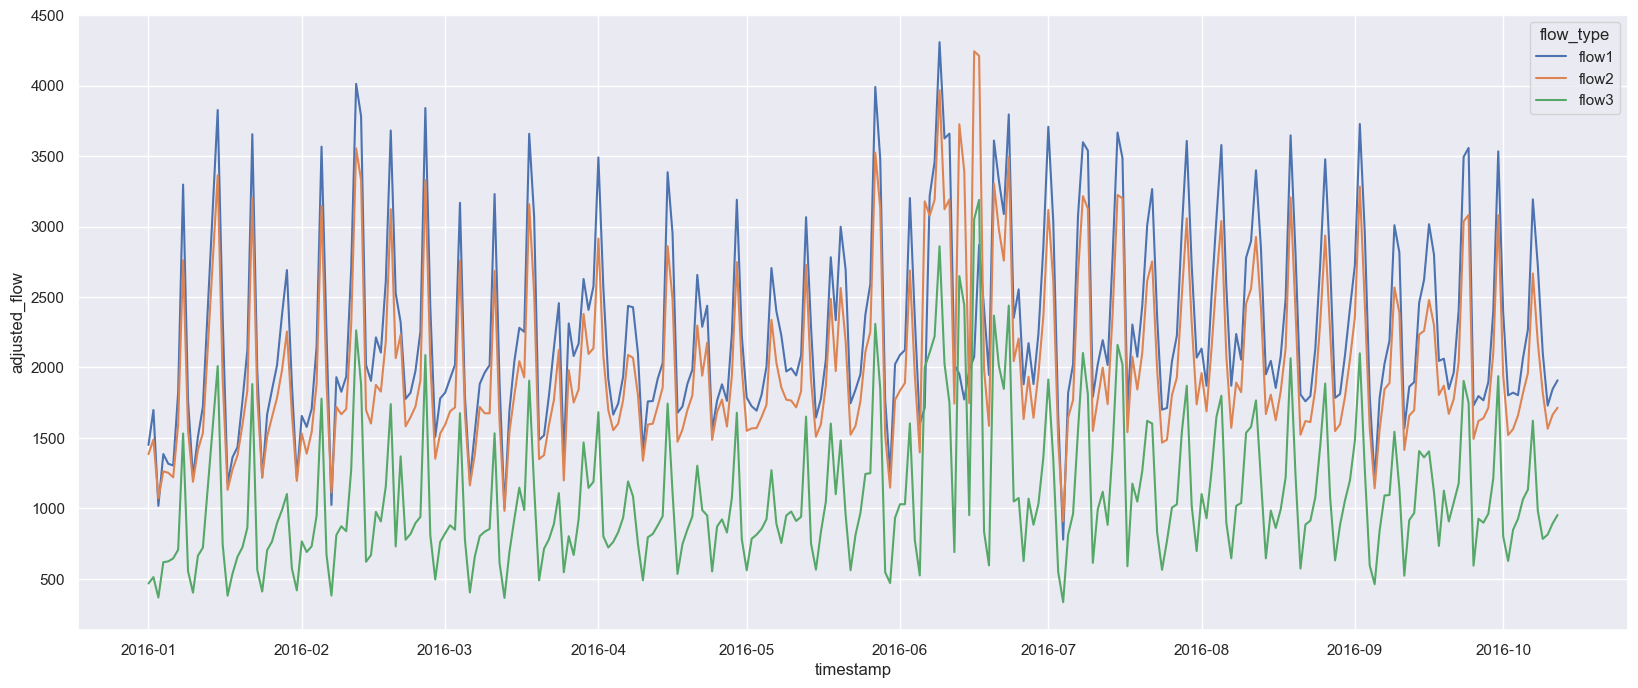

In [8]:
# Same plot but in Seaborn (so it's viewable on Github)
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot(data=df_plot, x='timestamp', y='adjusted_flow', hue='flow_type')

### Comparison of Avg Hourly Flows

In [9]:
# Hourly sum of flows (not adjusted), averaged across all days in the dataset
df_plot = arrivals.groupby(['flow_type', pd.Grouper(key='timestamp', freq='D'), 'hour']).flow.sum().reset_index()\
                  .groupby(['flow_type', 'hour']).flow.mean().reset_index()
px.line(df_plot, x='hour', y='flow', color='flow_type',
        title='Average Hourly Flow from 01/01/16 - 10/12/16')

<AxesSubplot:xlabel='hour', ylabel='flow'>

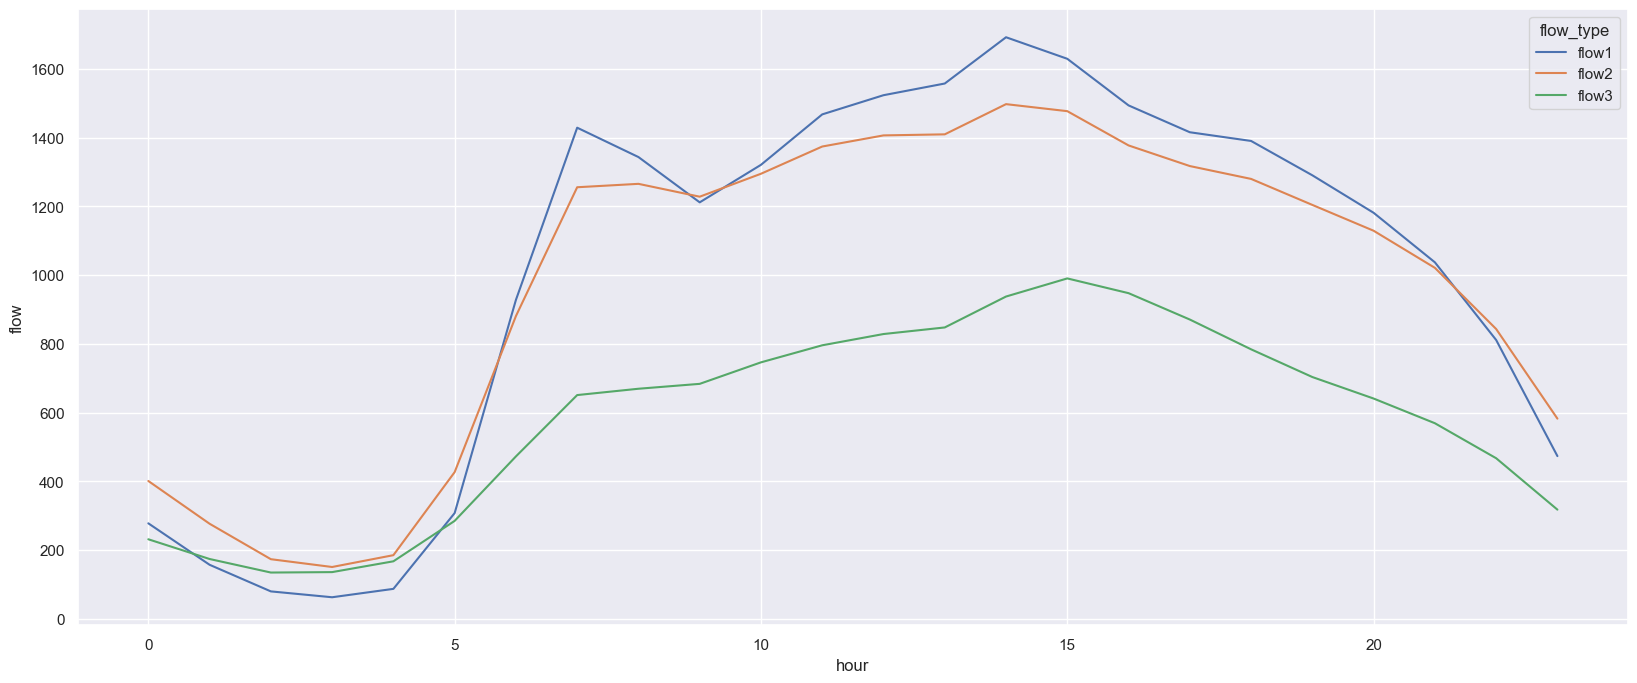

In [10]:
# Same plot but in Seaborn (so it's viewable on Github)
sns.lineplot(data=df_plot, x='hour', y='flow', hue='flow_type')

In [11]:
# Hourly sum of flows (adjusted), averaged across all days in the dataset
df_plot = arrivals.groupby(['flow_type', pd.Grouper(key='timestamp', freq='D'), 'hour']).adjusted_flow.sum().reset_index()\
                  .groupby(['flow_type', 'hour']).adjusted_flow.mean().reset_index()
px.line(df_plot, x='hour', y='adjusted_flow', color='flow_type',
        title='Average Hourly Adjusted Flow (`flow * occupancy`) from 01/01/16 - 10/12/16')

<AxesSubplot:xlabel='hour', ylabel='adjusted_flow'>

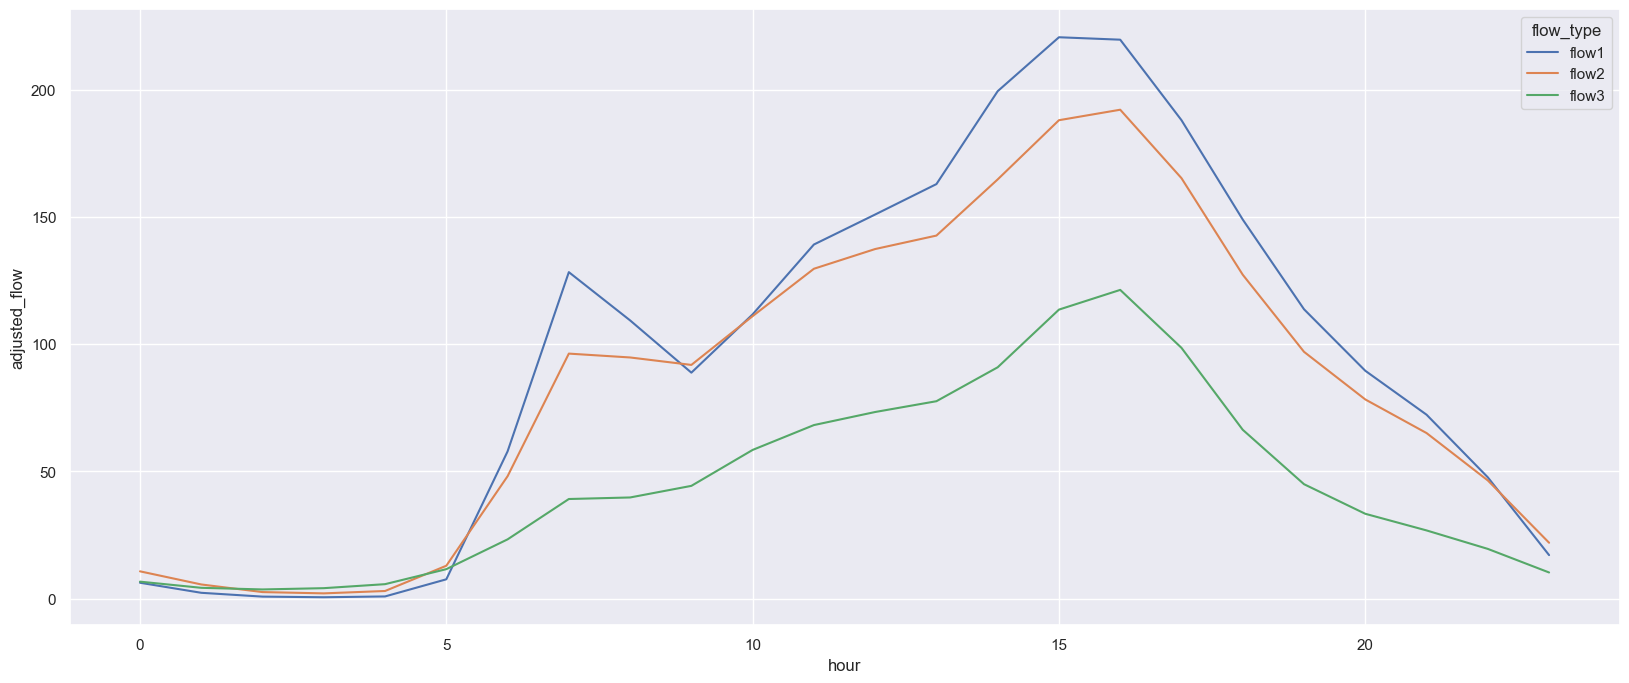

In [12]:
# Same plot but in Seaborn (so it's viewable on Github)
sns.lineplot(data=df_plot, x='hour', y='adjusted_flow', hue='flow_type')

### Augmented Dickey-Fuller Test (TBD)

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
# X = arrivals.query("flow_type=='flow1'")['adjusted_flow'].values

In [15]:
X = arrivals.query("flow_type=='flow1'").groupby(pd.Grouper(key='timestamp', freq='H')).adjusted_flow.sum().values

In [16]:
px.line(arrivals.query("flow_type=='flow1'").groupby(pd.Grouper(key='timestamp', freq='H')).adjusted_flow.sum())

In [17]:
# check the stationarity of time series using ADF 
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.618510
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [18]:
# confirm the stationarity of time series using Hurst exponent

import hurst

H, c,data = hurst.compute_Hc(X)
print("H = {:.4f}, c = {:.4f}".format(H,c))

H = 0.0787, c = 4.8947


In [19]:
# looking at flow 1, group data by hour
flow1 = arrivals[arrivals.flow_type=="flow1"].groupby(pd.Grouper(key='timestamp', freq='H')).adjusted_flow.sum().reset_index()

In [20]:
# plotting moving average for 24-hr rolling average

flow1['ma_daily'] = flow1.rolling(24).adjusted_flow.mean()
px.line(flow1, x='timestamp', y=['adjusted_flow', 'ma_daily'])

In [21]:
# plotting moving average and exponential smooting for 24-hr rolling average

alpha = 2/3
flow1['ewm'] = flow1.adjusted_flow.ewm(halflife='4 days', alpha=alpha, times=flow1.timestamp).mean()
px.line(flow1, x='timestamp', y=['adjusted_flow', 'ma_daily', 'ewm'])